In [1]:
import warnings
warnings.filterwarnings("ignore")
from soccerchain_wrap.helpers.plotting import (
    plot_sequences_by_id,
    plot_pass_clusters,
    plot_league_pizza_grid
)
from soccerchain_wrap.actions.spadl_io import SpadlIO
from soccerchain_wrap.sequences import (
    detect_buildup_sequences,
    detect_open_play_sequences,
    detect_shot_ending_sequences
)
from soccerchain_wrap.models.pass_clustering import BuildupInitiatingPassesCluster

from typing import Tuple, Optional, Iterable
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from soccerchain_wrap.metrics.pipe import metric_percentile_table_by_team, build_league_table
from soccerchain_wrap.metrics.sequence_summary import PitchDims

from typing import Optional, Iterable, Union, List
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from IPython.display import display
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
import joblib

# pip install tslearn mplsoccer scikit-learn
from itertools import combinations
from mplsoccer import Pitch

from tslearn.metrics import dtw
from sklearn.cluster import AgglomerativeClustering

[08/31/25 15:54:28] INFO     No custom team name replacements found. You can configure these in       ]8;id=507408;file:///Users/benallalyoussef/miniconda3/envs/socceraction_/lib/python3.9/site-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=438553;file:///Users/benallalyoussef/miniconda3/envs/socceraction_/lib/python3.9/site-packages/soccerdata/_config.py#91\91]8;;\
                             /Users/benallalyoussef/soccerdata/config/teamname_replacements.json.                  

                    INFO     Custom league dict loaded from                                          ]8;id=309831;file:///Users/benallalyoussef/miniconda3/envs/socceraction_/lib/python3.9/site-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=186007;file:///Users/benallalyoussef/miniconda3/envs/socceraction_/lib/python3.9/site-packages/soccerdata/_config.py#195\195]8;;\
                             /Users/benallalyoussef/soccerdata/config/league_dict.json.                            

# Data

### Actions data

In [2]:
# GET LEAGUE-SEASON ACTION DATA
spadl_io = SpadlIO(
    leagues=["ENG-Premier League"],
    seasons=[2024],
)

# TODO : automatic load if data already present
#spadl_io.save_spadl()
league_season_actions_dict = (
    spadl_io.load_spadl()
)

pl_actions_data = league_season_actions_dict['ENG-Premier League-2024']

### Percentile rank : playing style table

In [3]:
# Raw consolidated table
df_league_raw = build_league_table(pl_actions_data, dims=PitchDims())

# Percentile table (0..100) — only team + percentiles
df_pct = metric_percentile_table_by_team(
    pl_actions_data,
    dims=PitchDims(),
    include_raw=False,
)

# Playing style Framework

### Wheel plot

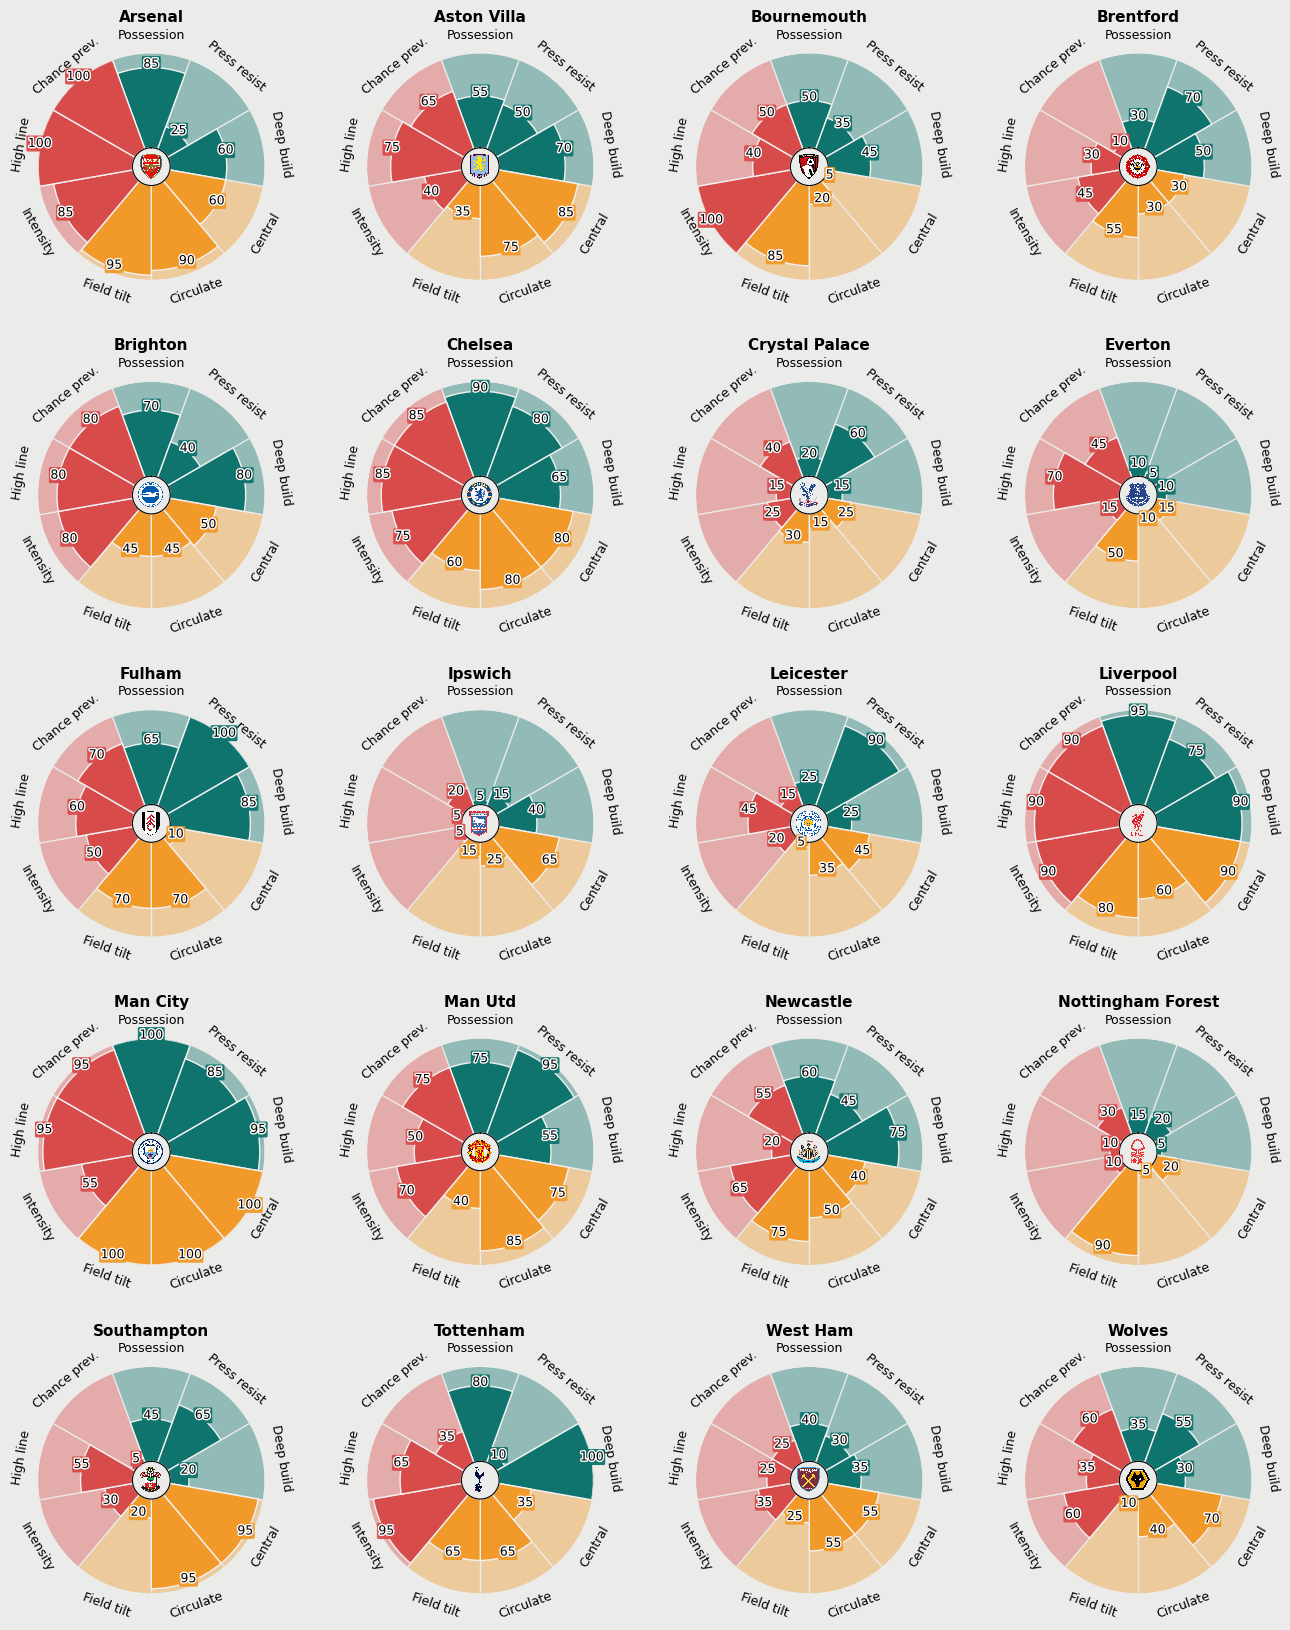

In [4]:
# ===== run it =====
fig = plot_league_pizza_grid(
    df_pct,
    team_name_col="team_name",
    ncols=4, nrows=5,
    figsize=(16, 20),
    sort_by="team_name",
    logo_dir="/Users/benallalyoussef/Sport-data-campus-master/PFM/soccerchain-wrap/assets",
    logo_zoom=0.035,
)
plt.show()

# Sequences

## Deep Buildup

### Clustering Initiating passes

In [8]:
# ------------------------------------ TRAINING ----------------------------------------
# cluster_model = BuildupInitiatingPassesCluster(def_third_x=35)
# pl_actions_data_cluster = cluster_model.fit(
#     pl_actions_data,
#     n_clusters=12,
#     show_plot=False
# )
# cluster_model.save("/Users/benallalyoussef/Sport-data-campus-master/PFM/soccerchain-wrap/models/initiating_pass_cluster.joblib")
init_pass_cluster_model = joblib.load('/Users/benallalyoussef/Sport-data-campus-master/PFM/soccerchain-wrap/models/initiating_pass_cluster.joblib')
pl_actions_data_cluster = init_pass_cluster_model.predict(pl_actions_data)

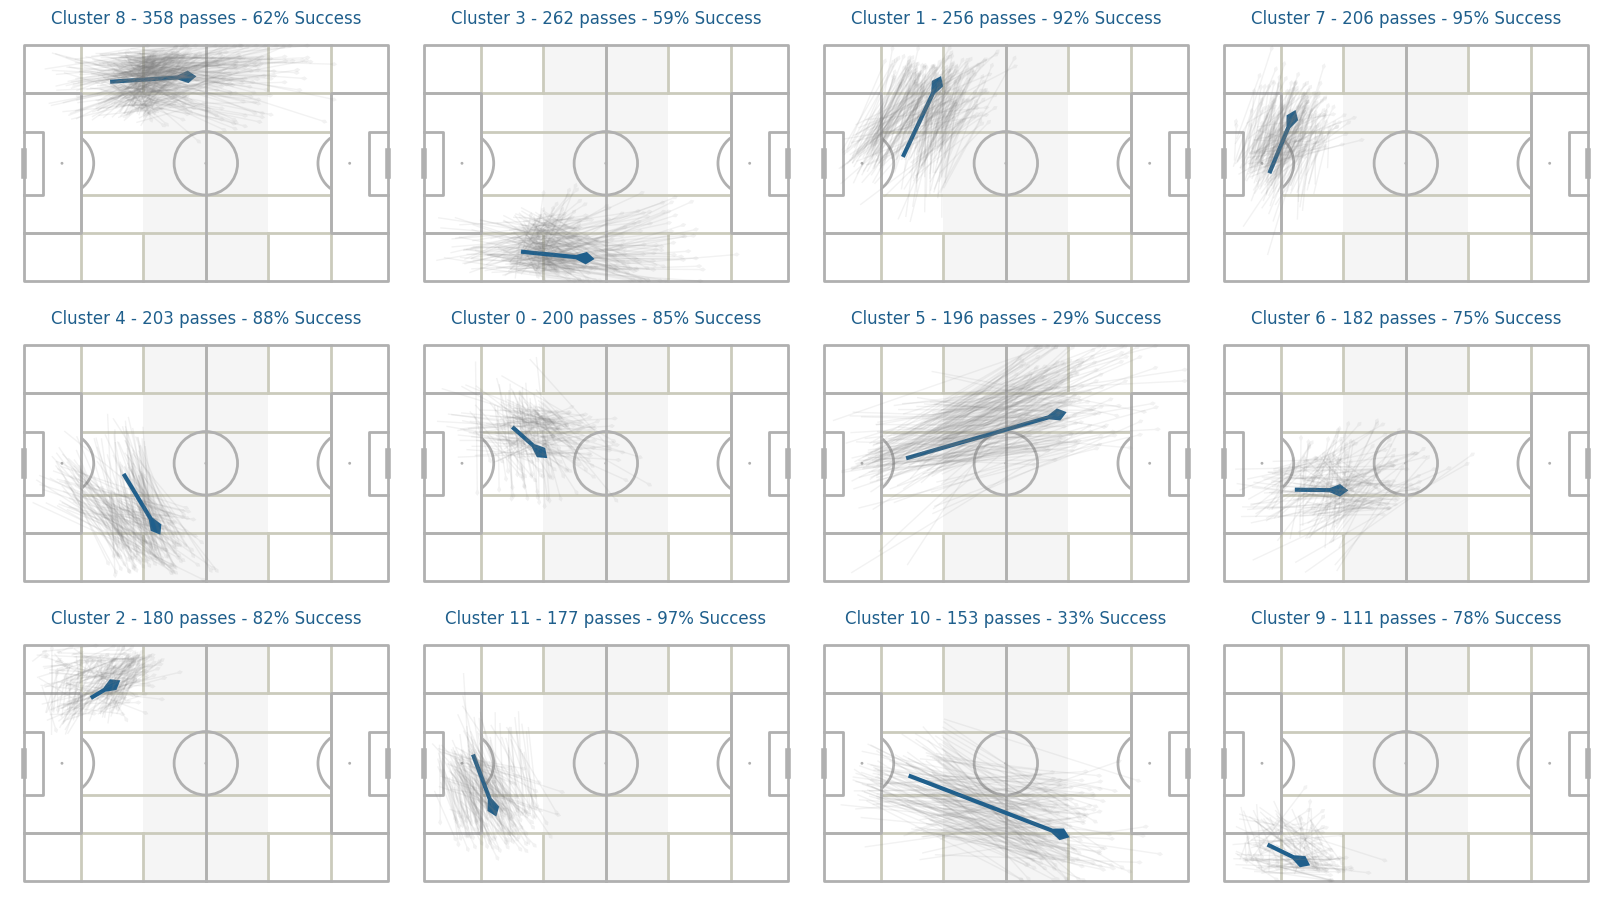

In [7]:
plot_pass_clusters(pl_actions_data_cluster, "Bournemouth", num_clusters=30, num_cols=4)

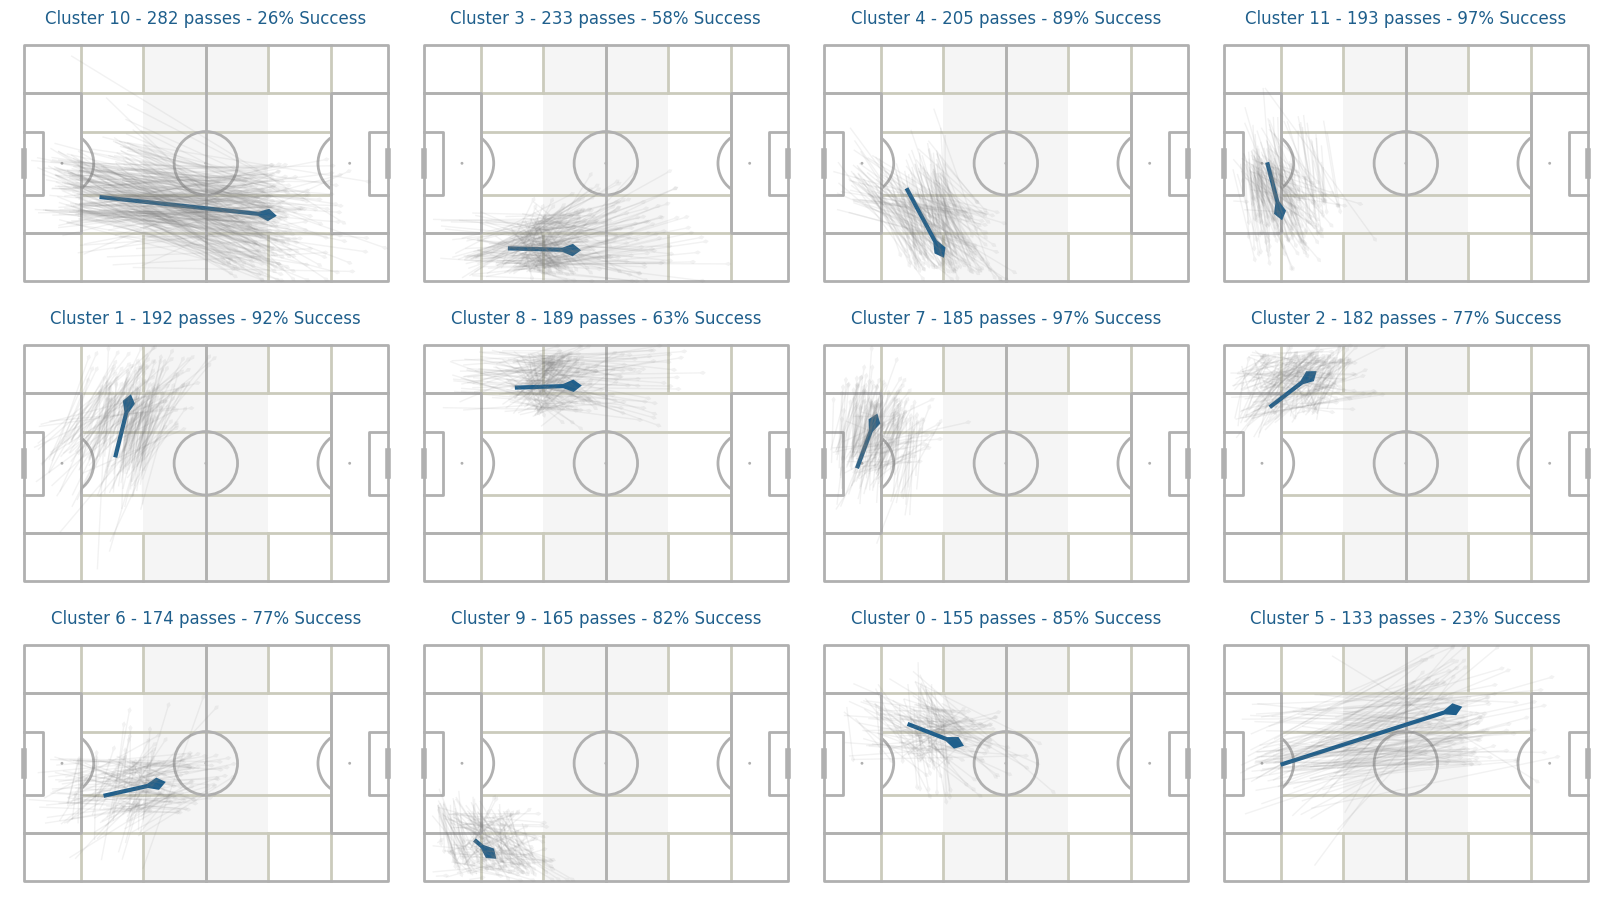

In [15]:
plot_pass_clusters(pl_actions_data_cluster, "Crystal Palace", num_clusters=30, num_cols=4)

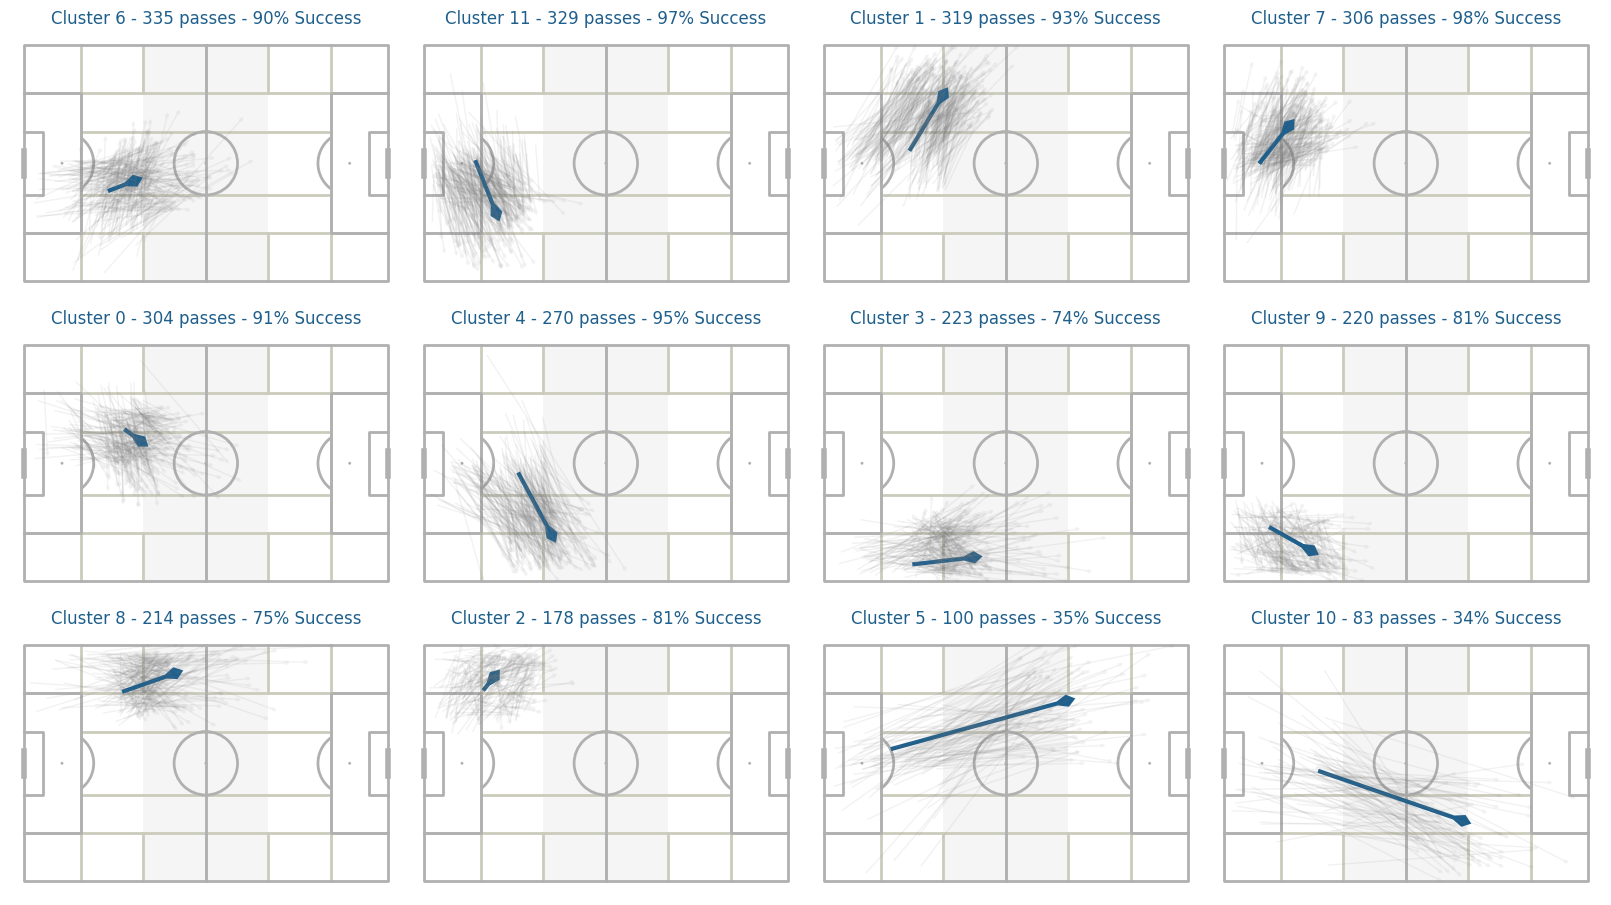

In [14]:
plot_pass_clusters(pl_actions_data_cluster, "Man City", num_clusters=30, num_cols=4)

### Get Deep buildup sequences

In [9]:
# DETECT BUILDUP SEQUENCES
pl_buildup_sequences = detect_buildup_sequences(
    pl_actions_data_cluster,
    defensive_third_max_x=35.0,
    halfway_x=52.5,
    apply_qc=True,
    qc_steps=("gap_flag", "interpolate"),
    dx_gap_thresh=20.0,
    dy_gap_thresh=13.0,
    interpolate_min_gap=1.0,
    interpolate_operate_on="clean",
)

In [13]:
pl_buildup_sequences.sequence_id.nunique()

12468

### Exploratory data analysis of buildup sequences

game_id    team_name      player_name  jersey_number type_name  start_x  \
0  1821080.0  Bournemouth     Mark Travers           42.0      pass   18.900   
1  1821080.0  Bournemouth  Antoine Semenyo           24.0   dribble   64.575   
2  1821080.0  Bournemouth  Antoine Semenyo           24.0      pass   74.445   

   start_y    end_x   end_y    sequence_id  period_id  pass_number  \
0   34.748   64.575  12.036  1821080-183-8        2.0            1   
1   12.036   74.445  25.024  1821080-183-8        2.0            1   
2   25.024  105.000  55.352  1821080-183-8        2.0            2   

   is_synthetic_carry  timestamp_min  
0               False          38.72  
1                True          38.80  
2               False          38.88

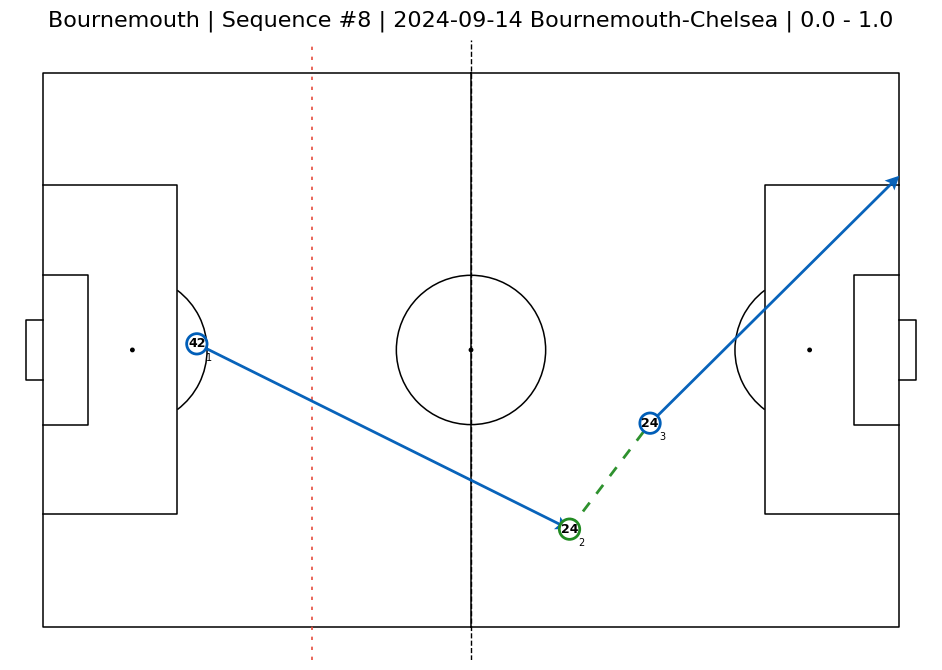

game_id    team_name       player_name  jersey_number type_name  start_x  \
0  1821169.0  Bournemouth              Kepa           13.0      pass   20.265   
1  1821169.0  Bournemouth         Evanilson            9.0      pass   76.020   
2  1821169.0  Bournemouth  Marcus Tavernier           16.0      pass   70.560   
3  1821169.0  Bournemouth   Justin Kluivert           19.0   dribble   70.350   
4  1821169.0  Bournemouth   Justin Kluivert           19.0      pass   71.400   
5  1821169.0  Bournemouth   Antoine Semenyo           24.0   dribble   81.270   
6  1821169.0  Bournemouth   Antoine Semenyo           24.0      pass   87.990   
7  1821169.0  Bournemouth      Milos Kerkez            3.0      pass  101.220   

   start_y    end_x   end_y    sequence_id  period_id  pass_number  \
0   34.204   76.020  20.468  1821169-183-4        1.0            1   
1   20.468   70.560  18.020  1821169-183-4        1.0            2   
2   18.020   70.350  23.324  1821169-183-4        1.0            3   
3   23.324   71.400  27.812  1821169-183-4        1.0            3   
4   27.812   81.270  55.148  1821169-183-4        1.0            4   
5   55.148   87.990  52.904  1821169-183-4        1.0            4   
6   52.904  100.590  46.580  1821169-183-4        1.0            5   
7   46.580  100.065  34.748  1821169-183-4        1.0            6   

   is_synthetic_carry  timestamp_min  
0               False          16.72  
1               False          16.80  
2               False          16.82  
3               False          16.84  
4               False          16.87  
5               False          16.89  
6               False          16.92  
7               False          16.95

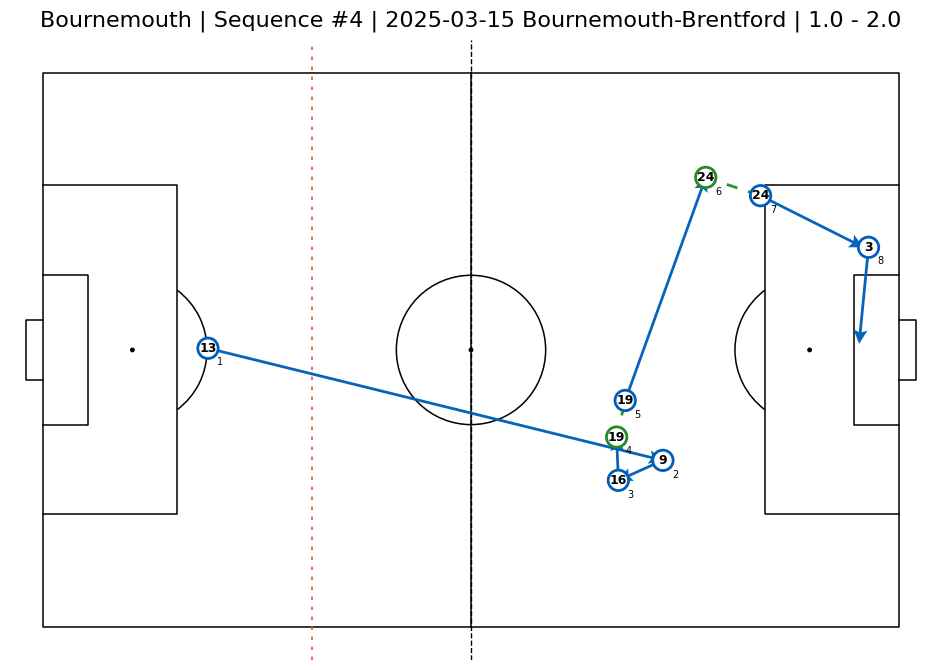

game_id    team_name      player_name  jersey_number type_name  start_x  \
0  1821206.0  Bournemouth             Kepa           13.0      pass   13.335   
1  1821206.0  Bournemouth  Antoine Semenyo           24.0      pass   61.845   
2  1821206.0  Bournemouth        Evanilson            9.0      pass   69.615   
3  1821206.0  Bournemouth  Justin Kluivert           19.0   dribble   79.590   
4  1821206.0  Bournemouth  Justin Kluivert           19.0      pass   78.225   
5  1821206.0  Bournemouth  Antoine Semenyo           24.0      shot   90.510   

   start_y    end_x   end_y    sequence_id  period_id  pass_number  \
0   29.240   61.845   8.160  1821206-183-1        1.0            1   
1    8.160   69.615  29.512  1821206-183-1        1.0            2   
2   29.512   79.590  36.312  1821206-183-1        1.0            3   
3   36.312   78.225  36.720  1821206-183-1        1.0            3   
4   36.720   90.510  27.880  1821206-183-1        1.0            4   
5   27.880  105.000  37.604  1821206-183-1        1.0            4   

   is_synthetic_carry  timestamp_min  
0               False          11.60  
1               False          11.65  
2               False          11.68  
3                True          11.70  
4               False          11.72  
5               False          11.75

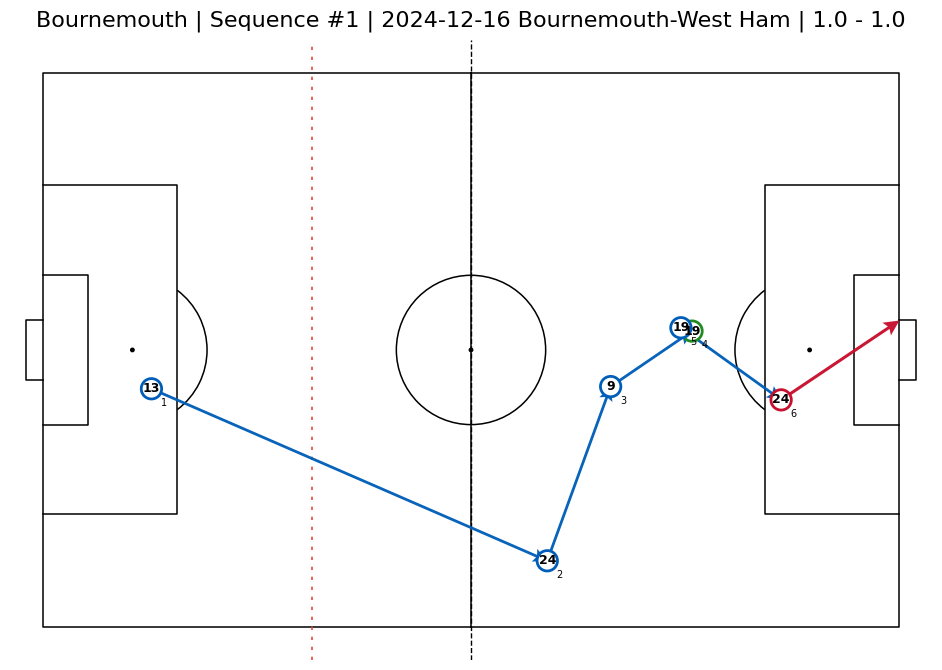

game_id    team_name      player_name  jersey_number type_name  start_x  \
0  1821259.0  Bournemouth             Kepa           13.0      pass   10.710   
1  1821259.0  Bournemouth  Antoine Semenyo           24.0      pass   63.525   
2  1821259.0  Bournemouth        Evanilson            9.0      pass   71.820   
3  1821259.0  Bournemouth  Antoine Semenyo           24.0   dribble   66.570   
4  1821259.0  Bournemouth  Antoine Semenyo           24.0      pass   68.355   
5  1821259.0  Bournemouth  Justin Kluivert           19.0   dribble   78.540   
6  1821259.0  Bournemouth  Justin Kluivert           19.0      pass   92.295   

   start_y   end_x   end_y    sequence_id  period_id  pass_number  \
0   31.416  64.260  12.852  1821259-183-7        1.0            1   
1   13.056  71.820  17.068  1821259-183-7        1.0            2   
2   17.068  66.570  22.848  1821259-183-7        1.0            3   
3   22.848  68.355  25.704  1821259-183-7        1.0            3   
4   25.704  78.540  52.700  1821259-183-7        1.0            4   
5   52.700  92.295  46.784  1821259-183-7        1.0            4   
6   46.784  92.505  44.676  1821259-183-7        1.0            5   

   is_synthetic_carry  timestamp_min  
0               False          45.28  
1               False          45.33  
2               False          45.37  
3               False          45.38  
4               False          45.40  
5               False          45.43  
6               False          45.47

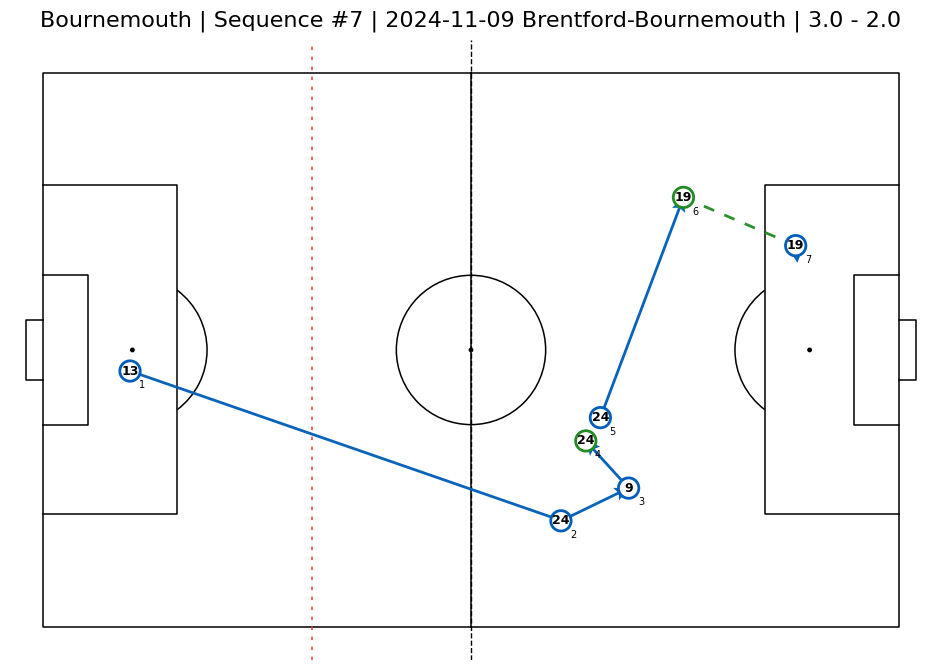

In [ ]:
# # PLOT BUILDUP SEQUENCES
# target_sequence_ids = pl_buildup_sequences[
#         (pl_buildup_sequences['team_name']=='Bournemouth')
#         &(pl_buildup_sequences['buildup_cluster']==3)
# ]['sequence_id'].unique()
# #["1821056-183-12", "1821056-183-13", "1821380-183-4", "1821426-183-6"]
# plot_sequences_by_id(
#     pl_buildup_sequences,
#     seq_ids_label3,
#     show_table=True, 
#     max_sequences=40
# )

### Test Sequence clustering

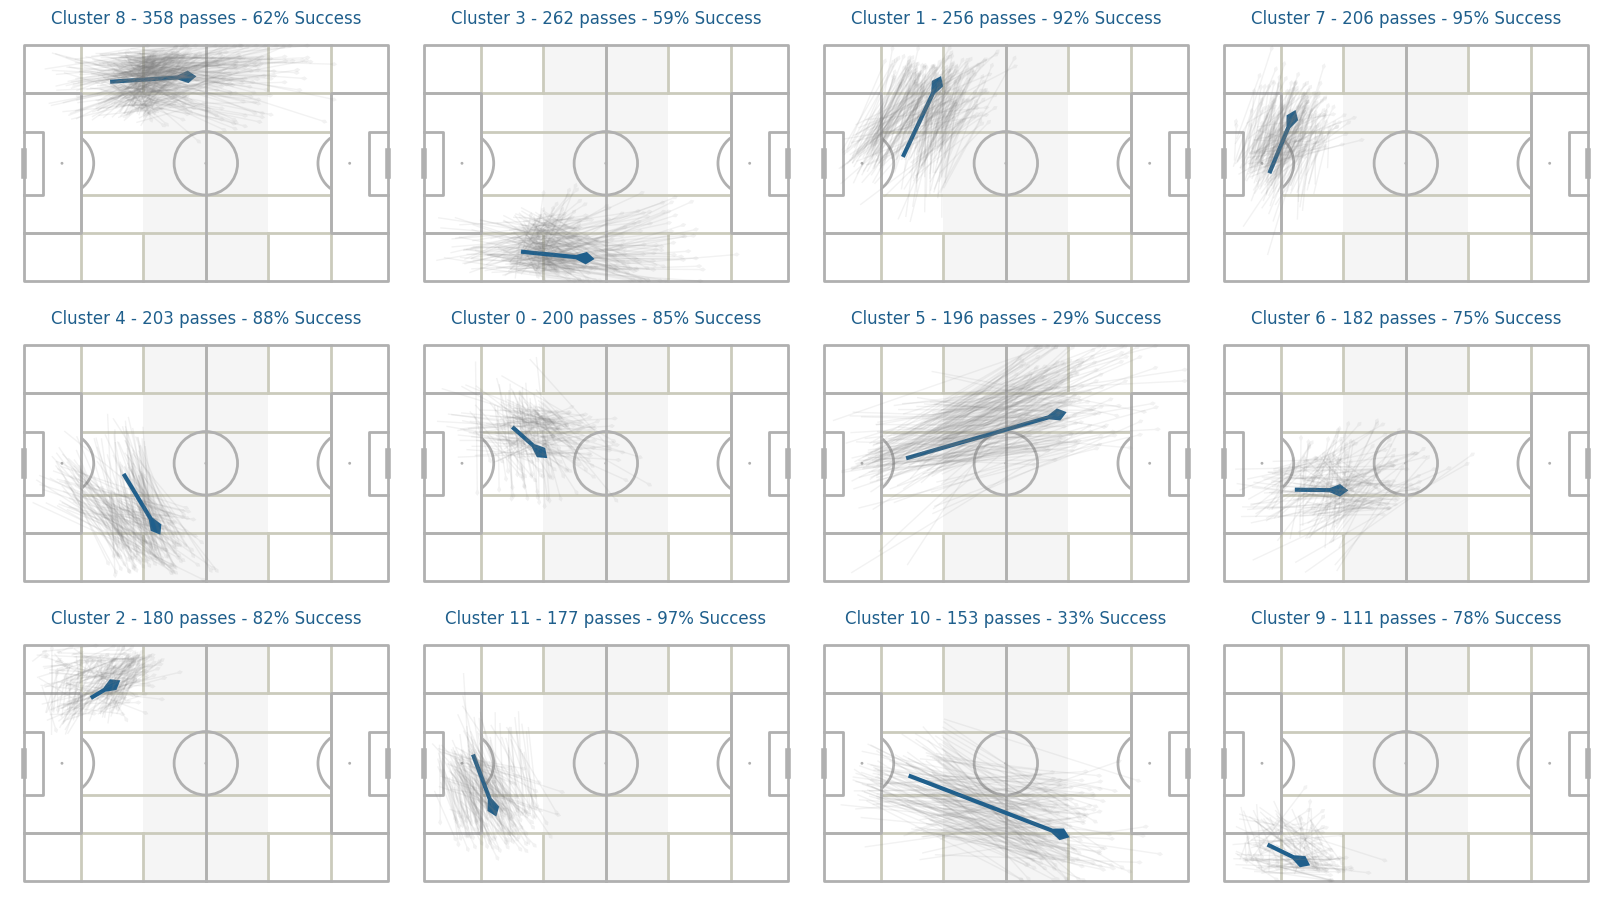

In [33]:
plot_pass_clusters(pl_actions_data_cluster, "Bournemouth", num_clusters=30, num_cols=4)

### Cluster paths

In [21]:
pl_actions_data_cluster[(pl_actions_data_cluster['buildup_cluster']==1) & (pl_actions_data_cluster['team_name']=="Liverpool") & (pl_actions_data_cluster['result_name']=="success")]

game_id original_event_id  period_id  time_seconds  team_id  \
4951    1821050        2709556129          1         886.0       26   
5102    1821050        2709565007          1        1460.0       26   
5103    1821050        2709565011          1        1461.0       26   
5129    1821050        2709566667          1        1579.0       26   
5130    1821050        2709566739          1        1591.0       26   
...         ...               ...        ...           ...      ...   
596404  1821331        2818936443          2         460.0       26   
596644  1821331        2818954811          2        1528.0       26   
596906  1821331        2818979287          2        2558.0       26   
596925  1821331        2818980775          2        2615.0       26   
596956  1821331        2818982711          2        2691.0       26   

        player_id  start_x   end_x  start_y   end_y  ...      player_name  \
4951     114147.0   27.510  33.810   33.116  45.492  ...   Alisson Becker   
5102      95408.0   28.140  29.820   36.720  46.308  ...  Virgil van Dijk   
5103     115726.0   29.820  37.065   46.308  59.908  ...   Andy Robertson   
5129     114147.0   22.470  26.250   42.364  56.440  ...   Alisson Becker   
5130      95408.0   28.140  28.455   41.004  54.128  ...  Virgil van Dijk   
...           ...      ...     ...      ...     ...  ...              ...   
596404   114147.0   11.340  25.305   42.568  58.208  ...   Alisson Becker   
596644    95408.0   32.340  37.905   39.712  50.660  ...  Virgil van Dijk   
596906   114147.0    7.455  30.975   34.884  63.852  ...   Alisson Becker   
596925    95408.0   28.455  30.345   36.856  51.884  ...  Virgil van Dijk   
596956    95408.0   14.070  24.465   38.284  56.372  ...  Virgil van Dijk   

        is_starter  minutes_played  jersey_number starting_position  \
4951          True             100              1                GK   
5102          True             100              4                DC   
5103          True              80             26                DL   
5129          True             100              1                GK   
5130          True             100              4                DC   
...            ...             ...            ...               ...   
596404        True              96              1                GK   
596644        True              96              4                DC   
596906        True              96              1                GK   
596925        True              96              4                DC   
596956        True              96              4                DC   

       former_position                                 game home_score  \
4951                GK         2024-08-17 Ipswich-Liverpool          0   
5102                DC         2024-08-17 Ipswich-Liverpool          0   
5103                DL         2024-08-17 Ipswich-Liverpool          0   
5129                GK         2024-08-17 Ipswich-Liverpool          0   
5130                DC         2024-08-17 Ipswich-Liverpool          0   
...                ...                                  ...        ...   
596404              GK  2025-05-25 Liverpool-Crystal Palace          1   
596644              DC  2025-05-25 Liverpool-Crystal Palace          1   
596906              GK  2025-05-25 Liverpool-Crystal Palace          1   
596925              DC  2025-05-25 Liverpool-Crystal Palace          1   
596956              DC  2025-05-25 Liverpool-Crystal Palace          1   

       away_score  buildup_cluster  
4951            2              1.0  
5102            2              1.0  
5103            2              1.0  
5129            2              1.0  
5130            2              1.0  
...           ...              ...  
596404          1              1.0  
596644          1              1.0  
596906          1              1.0  
596925          1              1.0  
596956          1              1.0  

[247 rows x 28 columns]

In [24]:
from soccerchain_wrap.models.sequence_clustering.utils import (
    trim_sequence,
    seq_directness,
    seq_width_index
)
from soccerchain_wrap.models.sequence_clustering.sequence_paths import (
    SequencePathCluster
)
from soccerchain_wrap.helpers.plotting import (
    plot_seq_clusters_grid
)

selected_sequences = pl_buildup_sequences[
    (pl_buildup_sequences['buildup_cluster']==1)
    &(pl_buildup_sequences['team_name']=='Liverpool')
].sequence_id.unique()
cluster_buildup_sequences = pl_buildup_sequences[
    (pl_buildup_sequences['sequence_id'].isin(selected_sequences))
]
cluster_buildup_sequences = trim_sequence(cluster_buildup_sequences, threshold=85.0)

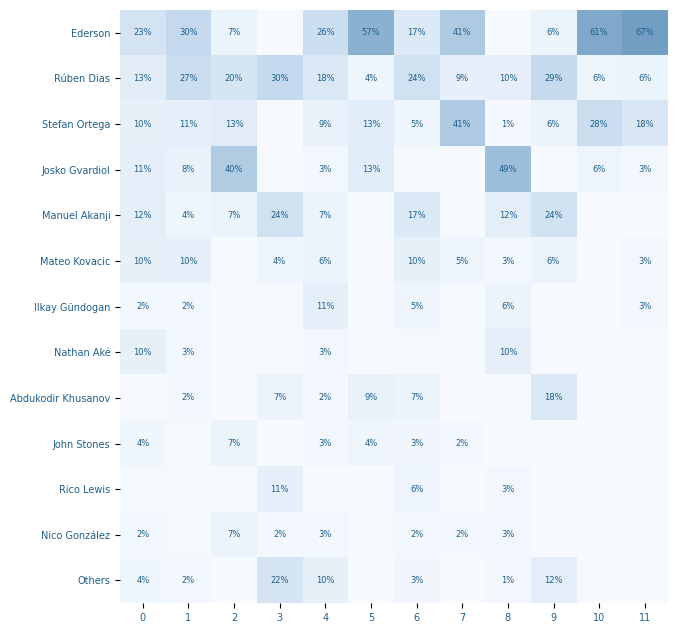

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

def prepare_initiations(df: pd.DataFrame) -> pd.DataFrame:
    # keep only rows that carry a buildup_cluster label
    d = df[df["buildup_cluster"].notna()].copy()
    if d.empty:
        return pd.DataFrame(columns=["sequence_id","team_name","player_name","buildup_cluster"])

    d["time_seconds"] = pd.to_numeric(d["time_seconds"], errors="coerce")

    # earliest event per sequence (tie-break by original_event_id if present)
    sort_cols = ["sequence_id", "time_seconds"]
    if "original_event_id" in d.columns:
        sort_cols.append("original_event_id")
    idx = (
        d.sort_values(sort_cols)
         .groupby("sequence_id", sort=False)
         .head(1)
         .index
    )

    keep_cols = [c for c in ["sequence_id","team_name","player_name","player_id",
                             "buildup_cluster","former_position"] if c in d.columns]
    out = d.loc[idx, keep_cols].copy()
    out["buildup_cluster"] = out["buildup_cluster"].astype(int)
    return out


import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_cluster_to_player_share_heatmap(df_init: pd.DataFrame,
                                         top_n: int = 15,
                                         add_others: bool = True,
                                         annot_min: float = 1.0,
                                         tick_size: int = 7,
                                         annot_size: int = 6):
    if df_init.empty:
        print("No initiations."); return

    ct = pd.crosstab(df_init["player_name"], df_init["buildup_cluster"])
    col_pct = 100 * ct.div(ct.sum(0).replace(0, np.nan), axis=1).fillna(0.0)

    totals = ct.sum(1).sort_values(ascending=False)
    top_players = [p for p in totals.index if p in col_pct.index][:top_n]
    col_pct = col_pct.loc[top_players]

    if add_others and len(ct) > len(top_players):
        others = (100 - col_pct.sum(0)).clip(lower=0)
        col_pct = pd.concat([col_pct, pd.DataFrame([others], index=["Others"])])

    col_pct = col_pct.reindex(sorted(col_pct.columns), axis=1)
    if "Others" in col_pct.index:
        col_pct = col_pct.loc[[p for p in col_pct.index if p != "Others"] + ["Others"]]

    cmap = LinearSegmentedColormap.from_list(
        "bluegrad", ["#F6FAFF", "#CFE1F2", "#9CBEDA", "#5E8FB8", "#1F5F8C"]
    )

    r, c = col_pct.shape
    cell = 0.4
    fig, ax = plt.subplots(figsize=(cell*c + 2.0, cell*r + 2.0))
    ax.imshow(col_pct.values, cmap=cmap, vmin=0, vmax=100, aspect="equal", interpolation="nearest")

    for s in ax.spines.values(): s.set_visible(False)

    ax.set_xticks(range(c)); ax.set_xticklabels(col_pct.columns, color="#1F5F8C", fontsize=tick_size)
    ax.set_yticks(range(r)); ax.set_yticklabels(col_pct.index,   color="#1F5F8C", fontsize=tick_size)

    for i in range(r):
        for j in range(c):
            v = col_pct.iat[i, j]
            if v >= annot_min:
                ax.text(j, i, f"{v:.0f}%", ha="center", va="center",
                        fontsize=annot_size, color="#1F5F8C")

    fig.tight_layout()
    plt.show()





buildup_sequences = pl_buildup_sequences[
    pl_buildup_sequences['team_name']=='Man City'
]
df_init = prepare_initiations(buildup_sequences)
df_team = df_init[df_init["team_name"] == "Man City"]
plot_cluster_to_player_share_heatmap(df_team, top_n=12, add_others=True)

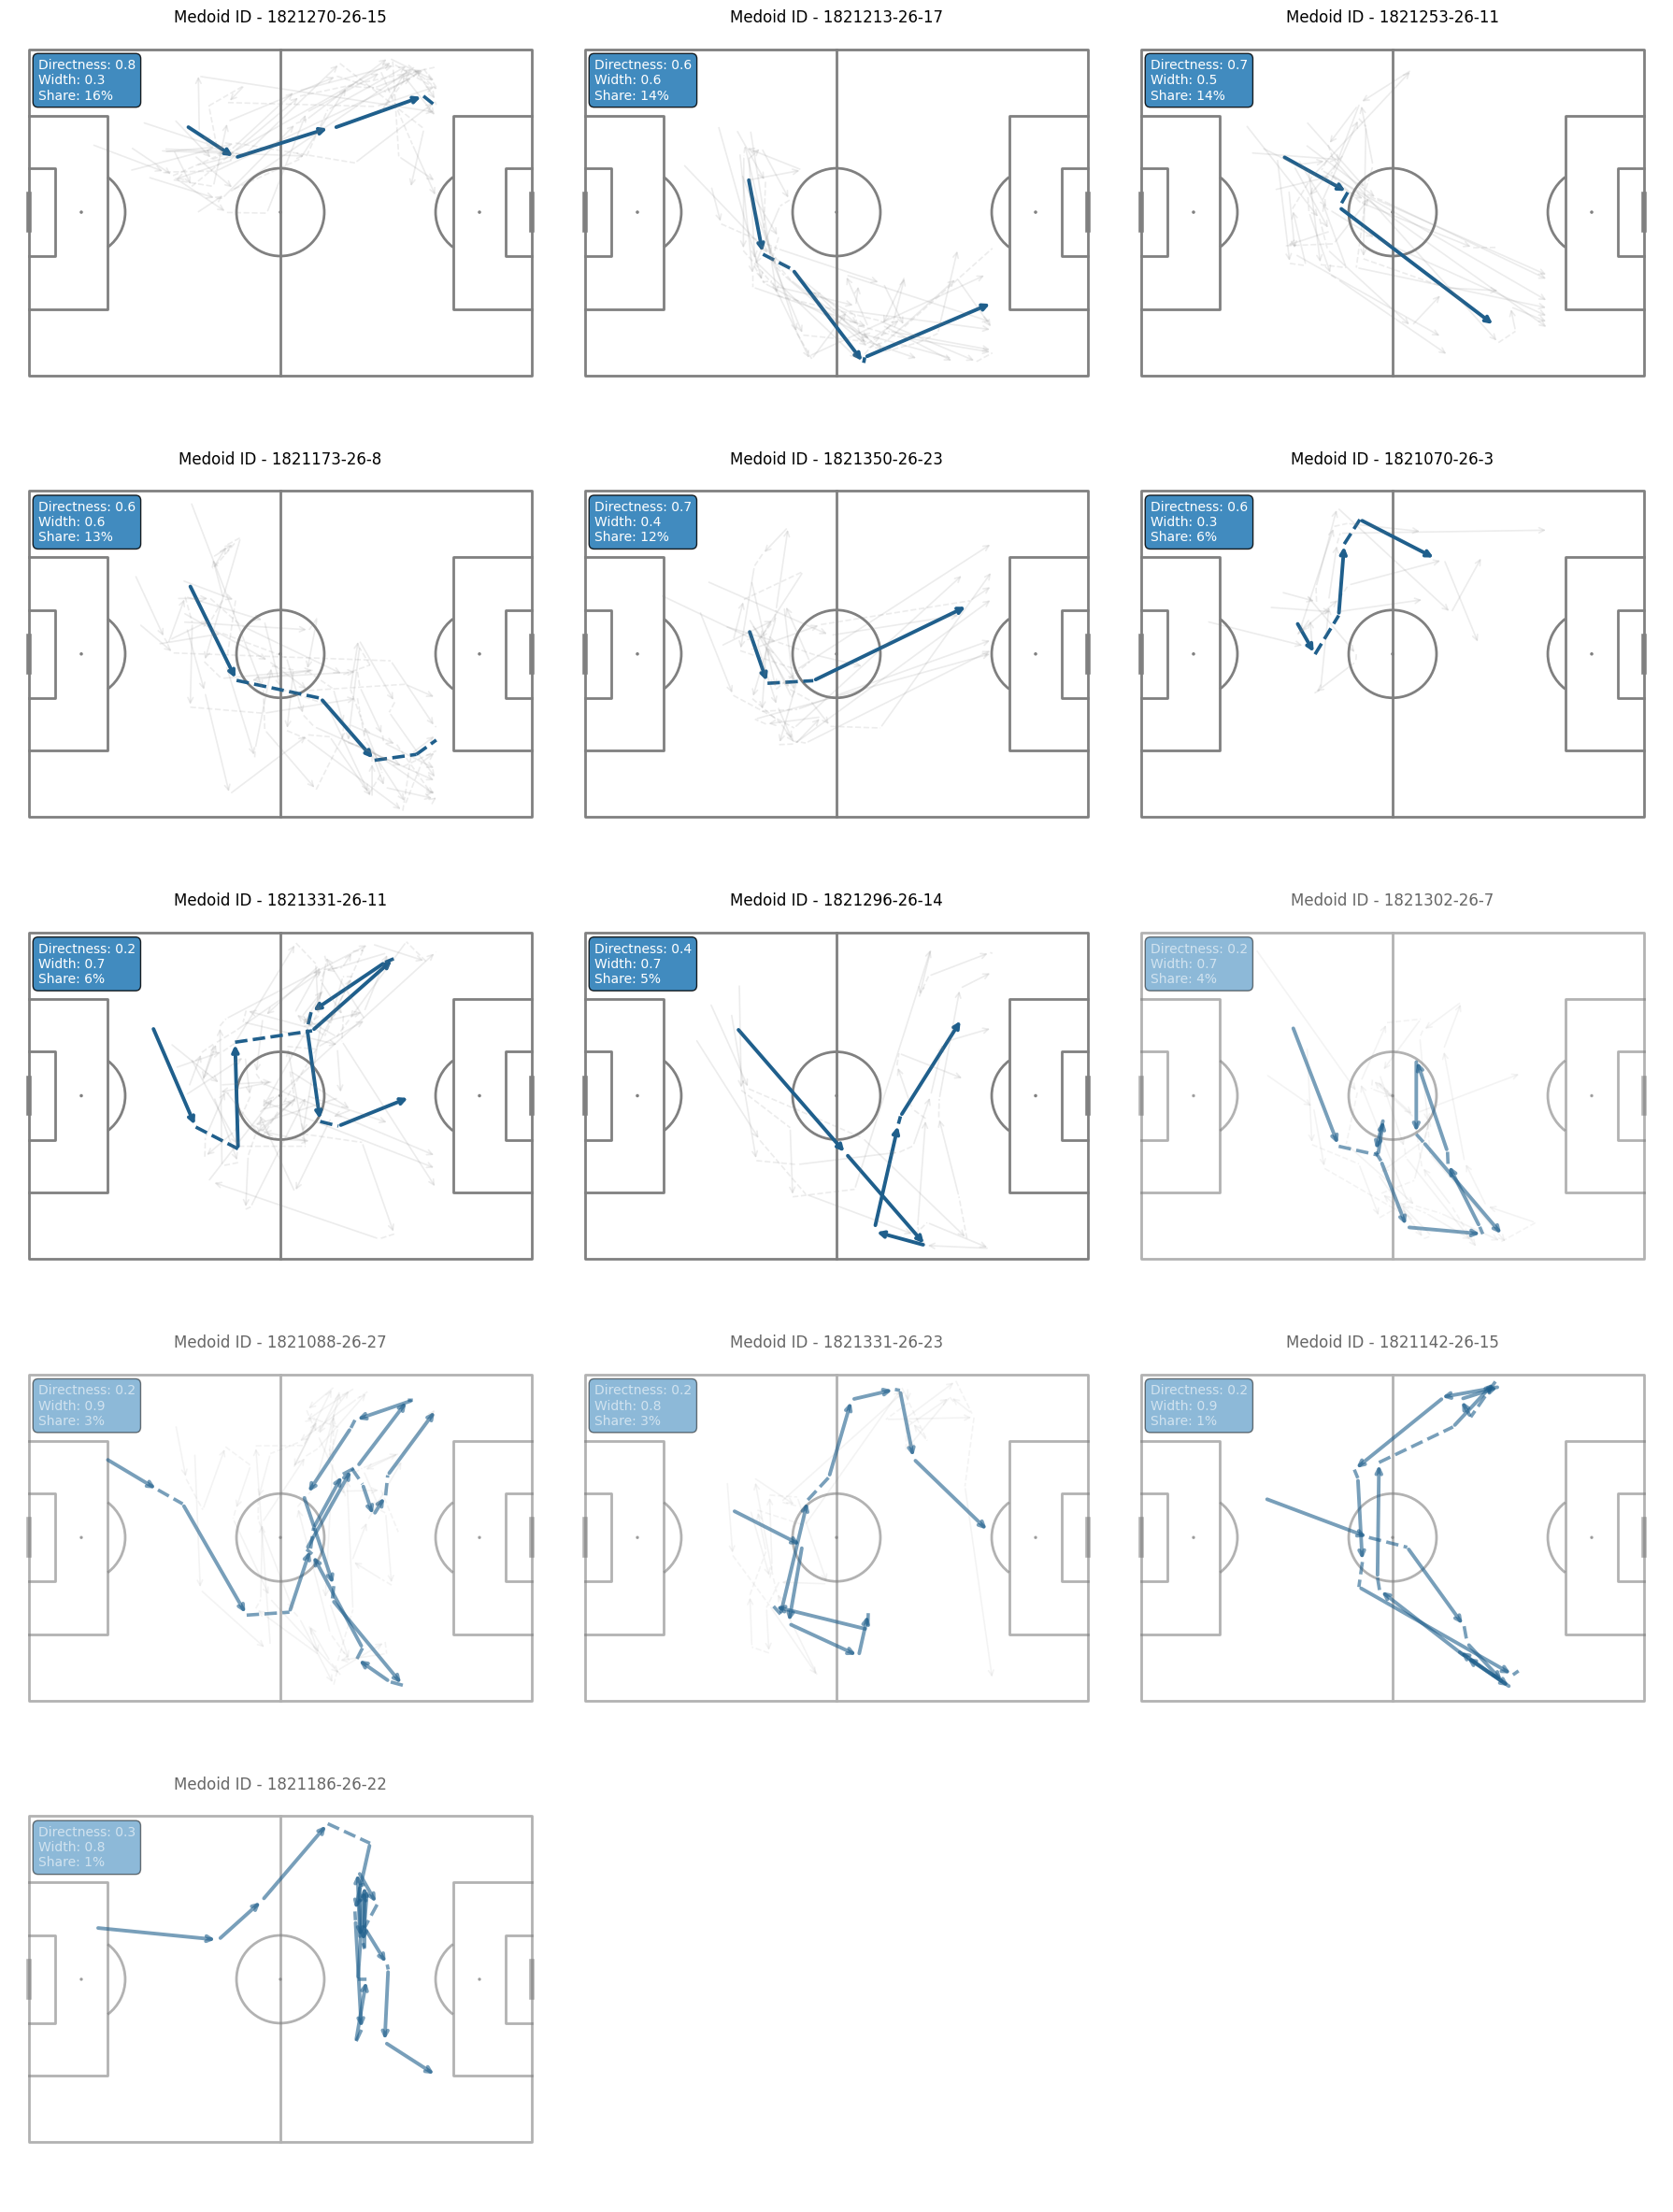

In [ ]:
res = SequencePathCluster().fit_predict(cluster_buildup_sequences)

#from soccerchain_wrap.helpers.plotting import plot_seq_clusters_grid
plot_seq_clusters_grid(
    df_events=cluster_buildup_sequences,
    results_dict=res,
    ncols=3,           # choose your grid width
    pitch_length=105,
    pitch_width=68
)

## Shot ending sequences

In [3]:
# DETECT BUILDUP SEQUENCES
shot_ending_sequences = detect_shot_ending_sequences(
    pl_actions_data,
    apply_qc=True,
    qc_steps=("gap_flag", "interpolate"),
    dx_gap_thresh=20.0,
    dy_gap_thresh=13.0,
    interpolate_min_gap=1.0,
    interpolate_operate_on="clean",
)
shot_ending_sequences

game_id original_event_id  period_id  time_seconds  team_id  \
0      1821049.0        2709318109        1.0         410.0    170.0   
1      1821049.0               NaN        1.0         413.5    170.0   
2      1821049.0        2709318147        1.0         417.0    170.0   
3      1821049.0               NaN        1.0         418.0    170.0   
4      1821049.0        2709318191        1.0         419.0    170.0   
...          ...               ...        ...           ...      ...   
56607  1821428.0        2779643883        2.0        3245.0     24.0   
56608  1821428.0               NaN        2.0        3248.5     24.0   
56609  1821428.0        2779643913        2.0        3252.0     24.0   
56610  1821428.0               NaN        2.0        3253.0     24.0   
56611  1821428.0        2779643925        2.0        3254.0     24.0   

       player_id  start_x   end_x  start_y   end_y  ...    sequence_id  \
0       297395.0   67.305  66.150   19.924  31.892  ...  1821049-170-1   
1       136824.0   66.150  63.105   31.892  50.116  ...  1821049-170-1   
2       136824.0   63.105  54.600   50.116  40.528  ...  1821049-170-1   
3       396976.0   54.600  54.600   40.528  39.304  ...  1821049-170-1   
4       396976.0   54.600  58.065   39.304  28.288  ...  1821049-170-1   
...          ...      ...     ...      ...     ...  ...            ...   
56607   137467.0   55.860  87.465   49.028  61.744  ...   1821428-24-9   
56608   300299.0   87.465  94.080   61.744  54.536  ...   1821428-24-9   
56609   300299.0   94.080  94.080   54.536  54.536  ...   1821428-24-9   
56610   300299.0   94.080  90.405   54.536  45.356  ...   1821428-24-9   
56611   300299.0   90.405  92.610   45.356  43.928  ...   1821428-24-9   

       in_sequence  sequence_valid  seq_num_passes seq_max_dx_gap  \
0             True            True            15.0          6.510   
1             True            True            15.0          6.510   
2             True            True            15.0          6.510   
3             True            True             NaN            NaN   
4             True            True            15.0          6.510   
...            ...             ...             ...            ...   
56607         True            True             1.0          3.675   
56608         True            True             1.0          3.675   
56609         True            True             1.0          3.675   
56610         True            True             NaN            NaN   
56611         True            True             1.0          3.675   

      seq_max_dy_gap seq_gap_dx_thresh seq_gap_dy_thresh sequence_gap  \
0              3.944              20.0              13.0          0.0   
1              3.944              20.0              13.0          0.0   
2              3.944              20.0              13.0          0.0   
3                NaN               NaN               NaN          NaN   
4              3.944              20.0              13.0          0.0   
...              ...               ...               ...          ...   
56607          9.180              20.0              13.0          0.0   
56608          9.180              20.0              13.0          0.0   
56609          9.180              20.0              13.0          0.0   
56610            NaN               NaN               NaN          NaN   
56611          9.180              20.0              13.0          0.0   

      is_synthetic_carry  
0                  False  
1                  False  
2                  False  
3                   True  
4                  False  
...                  ...  
56607              False  
56608              False  
56609              False  
56610               True  
56611              False  

[52485 rows x 37 columns]

In [15]:
target_sequence_ids = shot_ending_sequences[
        (shot_ending_sequences['team_name']=='Leicester')
]['sequence_id'].unique()
target_sequence_ids.shape

(179,)

In [33]:
pl_actions_data.shape

(606253, 27)

In [31]:
shot_ending_sequences[
        (shot_ending_sequences['team_name']=='Bournemouth')
]['seq_num_passes'].mean()

6.369470102090423

game_id team_name     player_name  jersey_number type_name  start_x  \
0   1821051.0  Man City   Mateo Kovacic            8.0      pass   26.355   
1   1821051.0  Man City      Rúben Dias            3.0   dribble   14.805   
2   1821051.0  Man City      Rúben Dias            3.0      pass   26.355   
3   1821051.0  Man City  Josko Gvardiol           24.0      pass   28.455   
4   1821051.0  Man City      Rúben Dias            3.0   dribble   26.460   
5   1821051.0  Man City      Rúben Dias            3.0      pass   37.065   
6   1821051.0  Man City  Josko Gvardiol           24.0   dribble   36.435   
7   1821051.0  Man City  Josko Gvardiol           24.0      pass   47.460   
8   1821051.0  Man City         Savinho           26.0   dribble   63.525   
9   1821051.0  Man City         Savinho           26.0      pass   71.820   
10  1821051.0  Man City  Bernardo Silva           20.0   dribble   85.260   
11  1821051.0  Man City  Bernardo Silva           20.0      shot   95.655   

    start_y   end_x   end_y    sequence_id  period_id  pass_number  \
0    23.528  14.805  33.524  1821051-167-1        1.0            1   
1    33.524  26.355  49.368  1821051-167-1        1.0            1   
2    49.368  28.455  56.168  1821051-167-1        1.0            2   
3    56.168  26.460  37.536  1821051-167-1        1.0            3   
4    37.536  37.065  31.484  1821051-167-1        1.0            3   
5    31.484  36.435  42.976  1821051-167-1        1.0            4   
6    42.976  47.460  49.504  1821051-167-1        1.0            4   
7    49.504  63.525  50.320  1821051-167-1        1.0            5   
8    50.320  71.820  49.096  1821051-167-1        1.0            5   
9    49.096  85.260  47.396  1821051-167-1        1.0            6   
10   47.396  95.655  44.880  1821051-167-1        1.0            6   
11   44.880  96.705  44.064  1821051-167-1        1.0            6   

    is_synthetic_carry  timestamp_min  
0                False           7.20  
1                False           7.28  
2                False           7.35  
3                False           7.40  
4                 True           7.48  
5                False           7.57  
6                False           7.61  
7                False           7.65  
8                False           7.68  
9                False           7.72  
10                True           7.73  
11               False           7.75

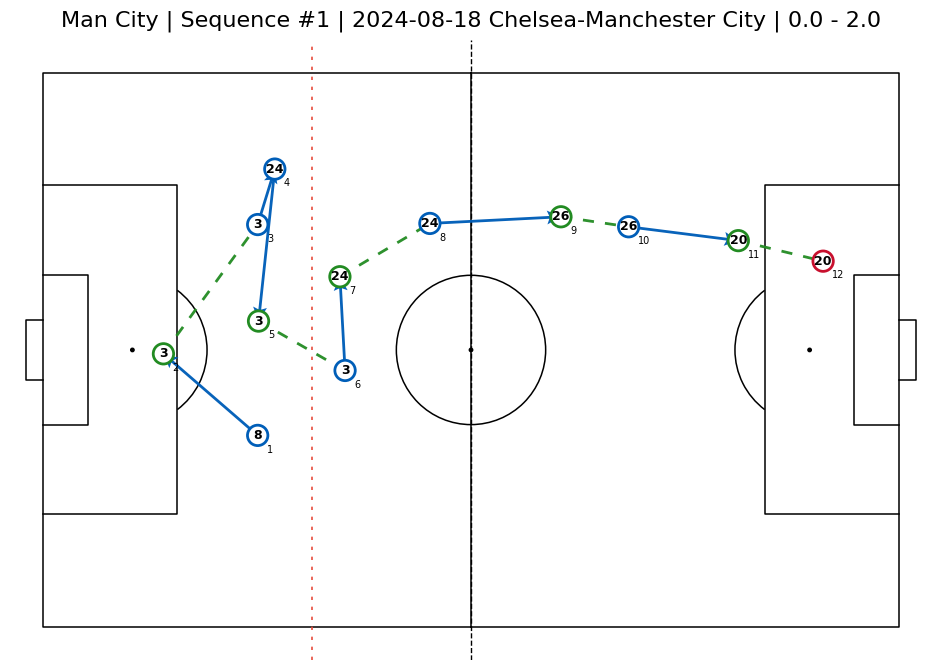

game_id team_name     player_name  jersey_number type_name  start_x  \
0  1821051.0  Man City         Savinho           26.0      pass   71.715   
1  1821051.0  Man City  Josko Gvardiol           24.0   dribble   62.685   
2  1821051.0  Man City  Josko Gvardiol           24.0      pass   72.870   
3  1821051.0  Man City      Rico Lewis           82.0   dribble   79.695   
4  1821051.0  Man City      Rico Lewis           82.0      pass   78.960   
5  1821051.0  Man City     Jérémy Doku           11.0      shot   92.295   

   start_y    end_x   end_y    sequence_id  period_id  pass_number  \
0   63.376   62.685  55.216  1821051-167-2        1.0            1   
1   55.216   72.870  51.884  1821051-167-2        1.0            1   
2   51.884   79.695  31.484  1821051-167-2        1.0            2   
3   31.484   78.960  34.612  1821051-167-2        1.0            2   
4   34.612   92.295  26.180  1821051-167-2        1.0            3   
5   26.180  105.000  52.904  1821051-167-2        1.0            3   

   is_synthetic_carry  timestamp_min  
0               False          10.58  
1               False          10.61  
2               False          10.63  
3               False          10.65  
4               False          10.67  
5               False          10.72

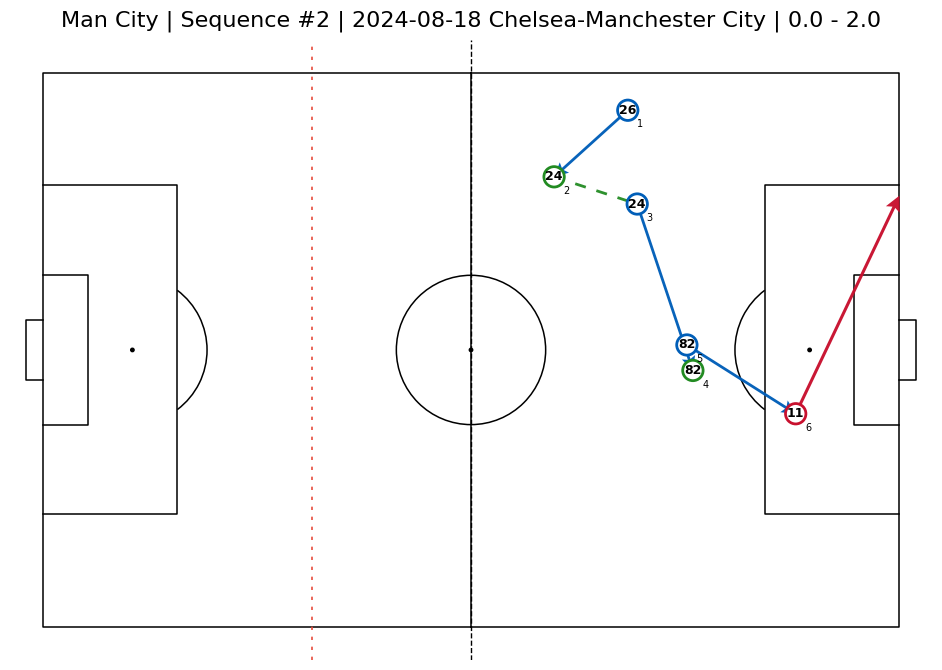

game_id team_name     player_name  jersey_number type_name  start_x  \
0   1821051.0  Man City   Manuel Akanji           25.0      pass   45.360   
1   1821051.0  Man City         Ederson           31.0   dribble   23.940   
2   1821051.0  Man City         Ederson           31.0      pass   26.880   
3   1821051.0  Man City      Rúben Dias            3.0   dribble   34.230   
4   1821051.0  Man City      Rúben Dias            3.0      pass   37.065   
5   1821051.0  Man City  Josko Gvardiol           24.0      pass   41.685   
6   1821051.0  Man City     Jérémy Doku           11.0   dribble   64.890   
7   1821051.0  Man City     Jérémy Doku           11.0      pass   78.435   
8   1821051.0  Man City  Bernardo Silva           20.0   dribble   91.665   
9   1821051.0  Man City  Bernardo Silva           20.0      pass   88.725   
10  1821051.0  Man City  Erling Haaland            9.0   dribble   90.825   
11  1821051.0  Man City  Erling Haaland            9.0   take_on   93.240   
12  1821051.0  Man City  Erling Haaland            9.0   dribble   93.240   
13  1821051.0  Man City  Erling Haaland            9.0      shot   97.230   

    start_y    end_x   end_y    sequence_id  period_id  pass_number  \
0    34.204   23.940  37.536  1821051-167-3        1.0            1   
1    37.536   26.880  39.372  1821051-167-3        1.0            1   
2    39.372   34.230  48.688  1821051-167-3        1.0            2   
3    48.688   37.065  49.980  1821051-167-3        1.0            2   
4    49.980   41.685  60.996  1821051-167-3        1.0            3   
5    60.996   64.890  64.668  1821051-167-3        1.0            4   
6    64.668   78.435  56.984  1821051-167-3        1.0            4   
7    56.984   91.665  40.528  1821051-167-3        1.0            5   
8    40.528   88.725  40.868  1821051-167-3        1.0            5   
9    40.868   90.825  30.600  1821051-167-3        1.0            6   
10   30.600   93.240  32.844  1821051-167-3        1.0            6   
11   32.844   93.240  32.844  1821051-167-3        1.0            6   
12   32.844   97.230  36.448  1821051-167-3        1.0            6   
13   36.448  105.000  33.388  1821051-167-3        1.0            6   

    is_synthetic_carry  timestamp_min  
0                False          17.45  
1                False          17.48  
2                False          17.52  
3                False          17.56  
4                False          17.60  
5                False          17.63  
6                False          17.70  
7                False          17.77  
8                 True          17.77  
9                False          17.78  
10               False          17.79  
11               False          17.80  
12                True          17.82  
13               False          17.85

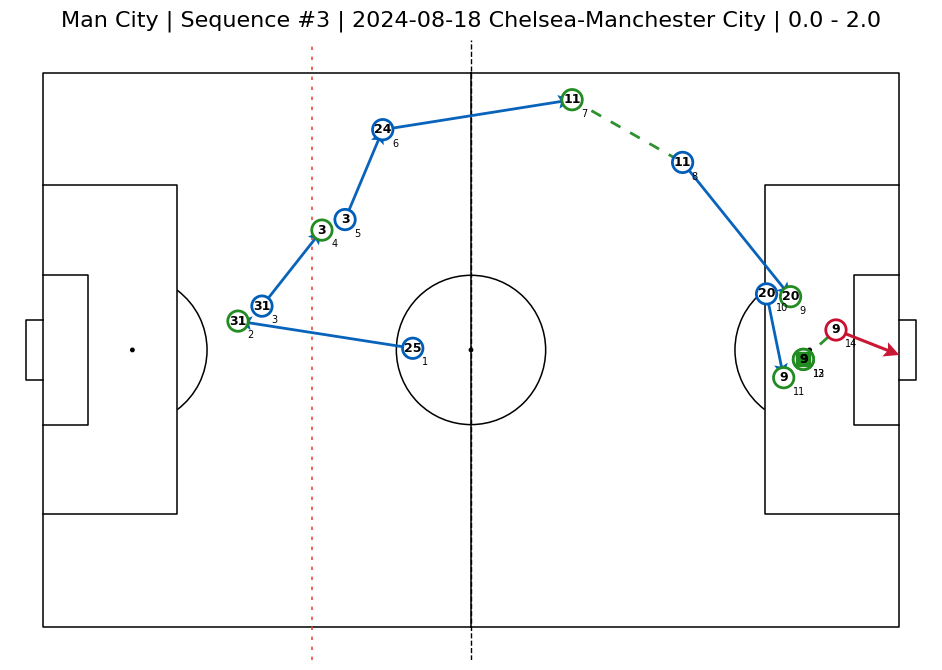

game_id team_name      player_name  jersey_number type_name  start_x  \
0   1821051.0  Man City       Rico Lewis           82.0      pass   72.240   
1   1821051.0  Man City          Savinho           26.0   dribble   77.910   
2   1821051.0  Man City          Savinho           26.0      pass   76.545   
3   1821051.0  Man City    Manuel Akanji           25.0   dribble   56.070   
4   1821051.0  Man City    Manuel Akanji           25.0      pass   38.220   
5   1821051.0  Man City          Ederson           31.0   dribble   13.335   
6   1821051.0  Man City          Ederson           31.0      pass   19.425   
7   1821051.0  Man City    Manuel Akanji           25.0   dribble   22.470   
8   1821051.0  Man City    Manuel Akanji           25.0      pass   24.360   
9   1821051.0  Man City    Mateo Kovacic            8.0   dribble   25.830   
10  1821051.0  Man City    Mateo Kovacic            8.0      pass   25.305   
11  1821051.0  Man City       Rico Lewis           82.0   dribble   46.830   
12  1821051.0  Man City       Rico Lewis           82.0      pass   47.250   
13  1821051.0  Man City          Savinho           26.0   dribble   60.270   
14  1821051.0  Man City          Savinho           26.0      pass   72.975   
15  1821051.0  Man City  Kevin De Bruyne           17.0   dribble   73.710   
16  1821051.0  Man City  Kevin De Bruyne           17.0      shot   80.745   

    start_y    end_x   end_y    sequence_id  period_id  pass_number  \
0    16.524   77.910   4.624  1821051-167-4        1.0            1   
1     4.624   76.545  11.152  1821051-167-4        1.0            1   
2    11.152   56.070   9.996  1821051-167-4        1.0            2   
3     9.996   38.220  11.152  1821051-167-4        1.0            2   
4    11.152   13.335  25.024  1821051-167-4        1.0            3   
5    25.024   19.425  30.532  1821051-167-4        1.0            3   
6    30.532   22.470  13.940  1821051-167-4        1.0            4   
7    13.940   24.360  11.968  1821051-167-4        1.0            4   
8    11.968   25.830  24.684  1821051-167-4        1.0            5   
9    24.684   25.305  20.468  1821051-167-4        1.0            5   
10   20.468   46.830  12.240  1821051-167-4        1.0            6   
11   12.240   47.250  11.016  1821051-167-4        1.0            6   
12   11.016   60.270   4.080  1821051-167-4        1.0            7   
13    4.080   72.975  24.956  1821051-167-4        1.0            7   
14   24.956   73.710  35.632  1821051-167-4        1.0            8   
15   35.632   80.745  35.020  1821051-167-4        1.0            8   
16   35.020  105.000  29.036  1821051-167-4        1.0            8   

    is_synthetic_carry  timestamp_min  
0                False          21.28  
1                False          21.33  
2                False          21.38  
3                False          21.43  
4                False          21.48  
5                False          21.52  
6                False          21.57  
7                 True          21.60  
8                False          21.63  
9                False          21.65  
10               False          21.67  
11                True          21.70  
12               False          21.73  
13               False          21.78  
14               False          21.83  
15                True          21.86  
16               False          21.88

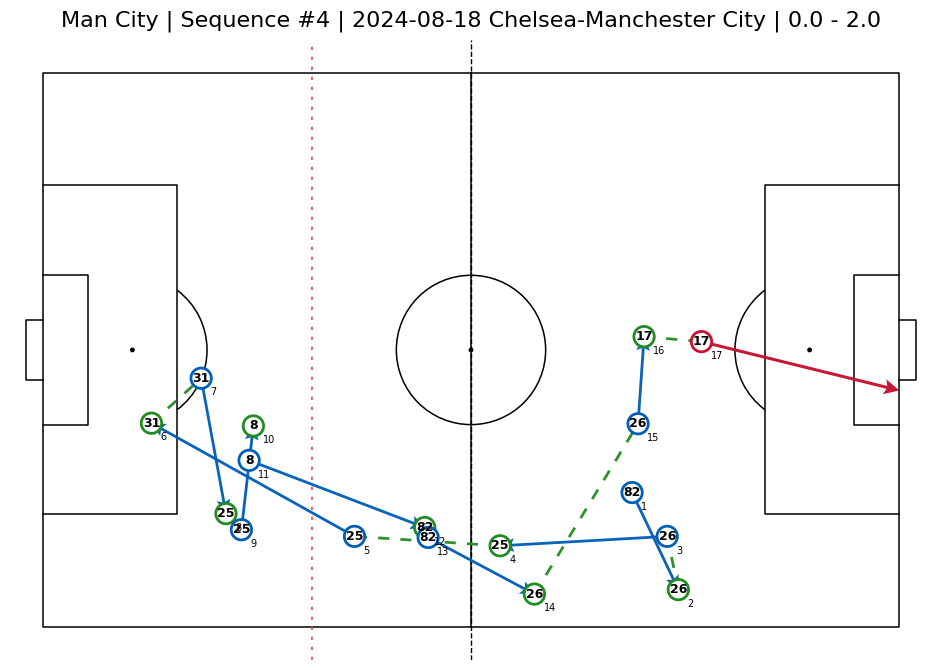

game_id team_name     player_name  jersey_number type_name  start_x  \
0   1821051.0  Man City         Ederson           31.0      pass   15.120   
1   1821051.0  Man City  Bernardo Silva           20.0   dribble   26.040   
2   1821051.0  Man City  Bernardo Silva           20.0      pass   33.285   
3   1821051.0  Man City      Rico Lewis           82.0      pass   33.915   
4   1821051.0  Man City   Mateo Kovacic            8.0   dribble   33.075   
5   1821051.0  Man City   Mateo Kovacic            8.0      pass   40.845   
6   1821051.0  Man City         Savinho           26.0   dribble   63.315   
7   1821051.0  Man City         Savinho           26.0   take_on   74.340   
8   1821051.0  Man City         Savinho           26.0   dribble   74.340   
9   1821051.0  Man City         Savinho           26.0      pass   96.705   
10  1821051.0  Man City   Mateo Kovacic            8.0      shot   84.000   

    start_y   end_x   end_y    sequence_id  period_id  pass_number  \
0    35.564  26.040  14.892  1821051-167-5        1.0            1   
1    14.892  33.285  13.532  1821051-167-5        1.0            1   
2    13.532  33.915  24.276  1821051-167-5        1.0            2   
3    24.276  33.075  35.088  1821051-167-5        1.0            3   
4    35.088  40.845  22.984  1821051-167-5        1.0            3   
5    22.984  63.315   6.460  1821051-167-5        1.0            4   
6     6.460  74.340  10.336  1821051-167-5        1.0            4   
7    10.336  74.340  10.336  1821051-167-5        1.0            4   
8    10.336  96.705  22.848  1821051-167-5        1.0            4   
9    22.848  83.580  28.016  1821051-167-5        1.0            5   
10   27.812  92.085  30.056  1821051-167-5        1.0            5   

    is_synthetic_carry  timestamp_min  
0                False          33.78  
1                False          33.82  
2                False          33.85  
3                False          33.88  
4                False          33.91  
5                False          33.93  
6                False          33.98  
7                False          34.02  
8                False          34.07  
9                False          34.12  
10               False          34.13

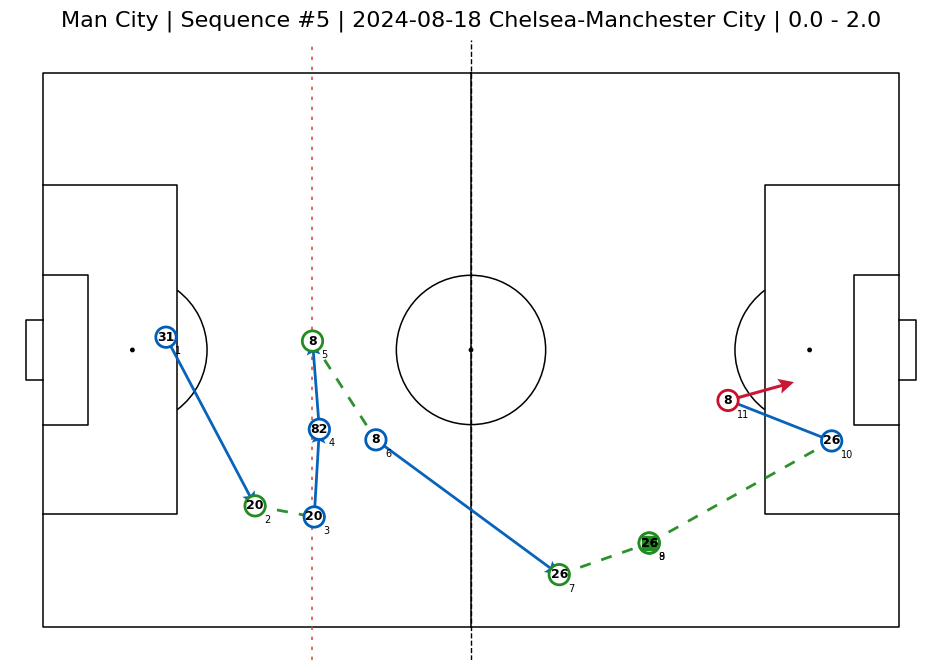

game_id team_name     player_name  jersey_number type_name  start_x  \
0  1821051.0  Man City      Rico Lewis           82.0      pass   67.305   
1  1821051.0  Man City   Mateo Kovacic            8.0   dribble   67.935   
2  1821051.0  Man City   Mateo Kovacic            8.0      pass   68.985   
3  1821051.0  Man City     Jérémy Doku           11.0   dribble   75.705   
4  1821051.0  Man City     Jérémy Doku           11.0      pass   80.010   
5  1821051.0  Man City  Josko Gvardiol           24.0   dribble   85.260   
6  1821051.0  Man City  Josko Gvardiol           24.0      shot   89.250   

   start_y   end_x   end_y    sequence_id  period_id  pass_number  \
0   46.308  67.935  55.488  1821051-167-6        1.0            1   
1   55.488  68.985  55.488  1821051-167-6        1.0            1   
2   55.488  75.705  63.988  1821051-167-6        1.0            2   
3   63.988  80.010  62.696  1821051-167-6        1.0            2   
4   62.696  85.260  49.368  1821051-167-6        1.0            3   
5   49.368  89.250  47.124  1821051-167-6        1.0            3   
6   47.124  92.295  44.948  1821051-167-6        1.0            3   

   is_synthetic_carry  timestamp_min  
0               False          37.32  
1                True          37.33  
2               False          37.35  
3               False          37.38  
4               False          37.40  
5                True          37.42  
6               False          37.45

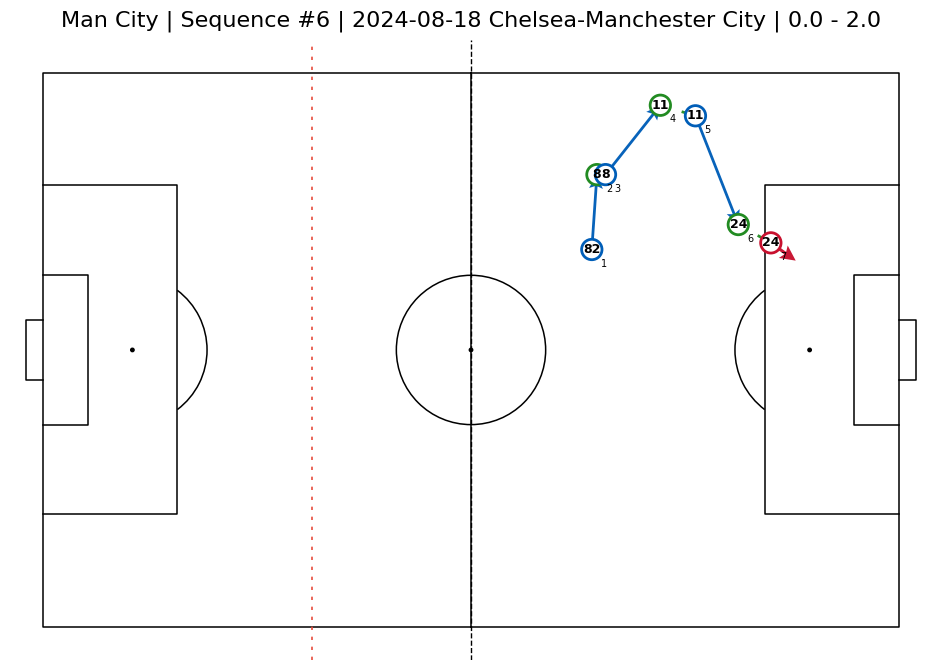

game_id team_name      player_name  jersey_number type_name  start_x  \
0  1821051.0  Man City          Savinho           26.0      pass   57.435   
1  1821051.0  Man City      Jérémy Doku           11.0   dribble   75.705   
2  1821051.0  Man City      Jérémy Doku           11.0      pass   82.635   
3  1821051.0  Man City  Kevin De Bruyne           17.0      pass   77.385   
4  1821051.0  Man City   Bernardo Silva           20.0   dribble   85.260   
5  1821051.0  Man City   Bernardo Silva           20.0      shot   93.975   

   start_y    end_x   end_y    sequence_id  period_id  pass_number  \
0    3.672   75.705  12.784  1821051-167-7        1.0            1   
1   12.784   82.635  20.944  1821051-167-7        1.0            1   
2   20.944   77.385  32.980  1821051-167-7        1.0            2   
3   32.980   85.260  44.540  1821051-167-7        1.0            3   
4   44.540   93.975  46.036  1821051-167-7        1.0            3   
5   46.036  103.740  36.924  1821051-167-7        1.0            3   

   is_synthetic_carry  timestamp_min  
0               False          39.28  
1               False          39.32  
2               False          39.35  
3               False          39.38  
4                True          39.42  
5               False          39.47

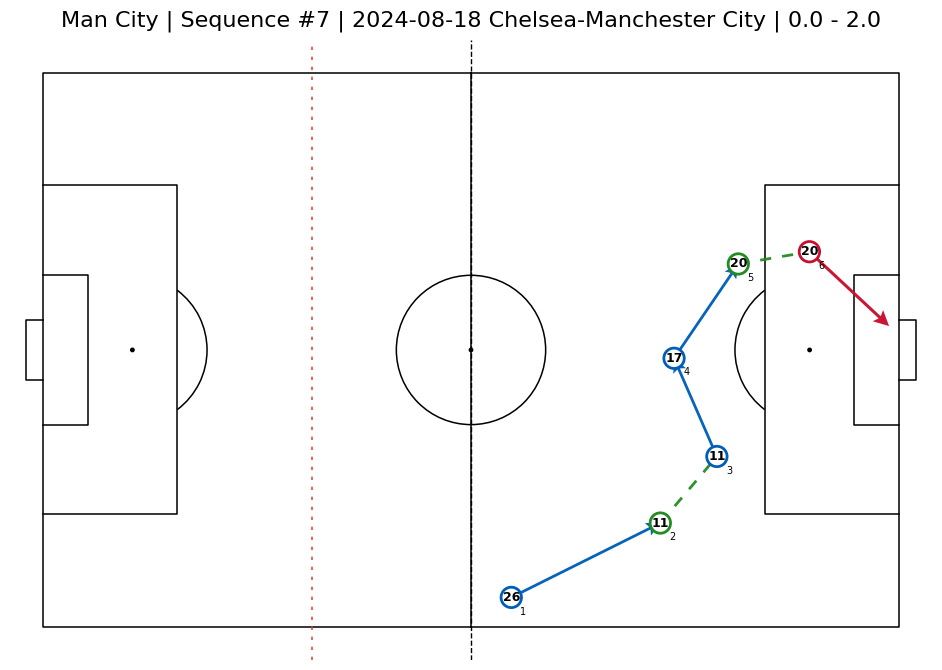

game_id team_name      player_name  jersey_number type_name  start_x  \
0   1821051.0  Man City          Ederson           31.0      pass   15.960   
1   1821051.0  Man City   Bernardo Silva           20.0   dribble   34.440   
2   1821051.0  Man City   Bernardo Silva           20.0      pass   41.475   
3   1821051.0  Man City       Phil Foden           47.0   dribble   49.875   
4   1821051.0  Man City       Phil Foden           47.0      pass   38.850   
5   1821051.0  Man City    Mateo Kovacic            8.0   dribble   37.380   
6   1821051.0  Man City    Mateo Kovacic            8.0      pass   37.485   
7   1821051.0  Man City       Phil Foden           47.0   dribble   33.180   
8   1821051.0  Man City       Phil Foden           47.0      pass   32.025   
9   1821051.0  Man City       Rúben Dias            3.0      pass   29.715   
10  1821051.0  Man City    Mateo Kovacic            8.0   dribble   39.690   
11  1821051.0  Man City    Mateo Kovacic            8.0      pass   40.215   
12  1821051.0  Man City   Josko Gvardiol           24.0   dribble   40.110   
13  1821051.0  Man City   Josko Gvardiol           24.0      pass   39.900   
14  1821051.0  Man City      Jérémy Doku           11.0   dribble   55.125   
15  1821051.0  Man City      Jérémy Doku           11.0   take_on   60.480   
16  1821051.0  Man City      Jérémy Doku           11.0   dribble   60.480   
17  1821051.0  Man City      Jérémy Doku           11.0      pass   71.505   
18  1821051.0  Man City   Bernardo Silva           20.0   dribble   67.200   
19  1821051.0  Man City   Bernardo Silva           20.0      pass   72.030   
20  1821051.0  Man City  Kevin De Bruyne           17.0   dribble   74.235   
21  1821051.0  Man City  Kevin De Bruyne           17.0      pass   72.240   
22  1821051.0  Man City   Josko Gvardiol           24.0      pass   74.760   
23  1821051.0  Man City    Mateo Kovacic            8.0   dribble   64.575   
24  1821051.0  Man City    Mateo Kovacic            8.0      pass   71.610   
25  1821051.0  Man City  Kevin De Bruyne           17.0   dribble   72.450   
26  1821051.0  Man City  Kevin De Bruyne           17.0      pass   71.400   
27  1821051.0  Man City      Jérémy Doku           11.0   dribble   84.000   
28  1821051.0  Man City      Jérémy Doku           11.0      pass   85.680   
29  1821051.0  Man City  Kevin De Bruyne           17.0      pass   79.170   
30  1821051.0  Man City   Bernardo Silva           20.0      pass   91.560   
31  1821051.0  Man City   Erling Haaland            9.0   dribble   90.930   
32  1821051.0  Man City   Erling Haaland            9.0      shot   89.880   

    start_y    end_x   end_y    sequence_id  period_id  pass_number  \
0    22.644   34.440  22.372  1821051-167-8        2.0            1   
1    22.372   41.475  19.992  1821051-167-8        2.0            1   
2    19.992   49.875   6.528  1821051-167-8        2.0            2   
3     6.528   38.850  12.104  1821051-167-8        2.0            2   
4    12.104   37.380  24.820  1821051-167-8        2.0            3   
5    24.820   37.485  23.188  1821051-167-8        2.0            3   
6    23.188   33.180  13.464  1821051-167-8        2.0            4   
7    13.464   32.025  17.340  1821051-167-8        2.0            4   
8    17.340   29.085  38.012  1821051-167-8        2.0            5   
9    38.692   39.690  37.876  1821051-167-8        2.0            6   
10   37.876   40.215  43.520  1821051-167-8        2.0            6   
11   43.520   40.110  54.672  1821051-167-8        2.0            7   
12   54.672   39.900  57.528  1821051-167-8        2.0            7   
13   57.528   55.125  66.028  1821051-167-8        2.0            8   
14   66.028   60.480  56.100  1821051-167-8        2.0            8   
15   56.100   60.480  56.100  1821051-167-8        2.0            8   
16   56.100   71.505  45.492  1821051-167-8        2.0            8   
17   45.492   67.200  37.672  1821051-167-8        2.0            9   
18  

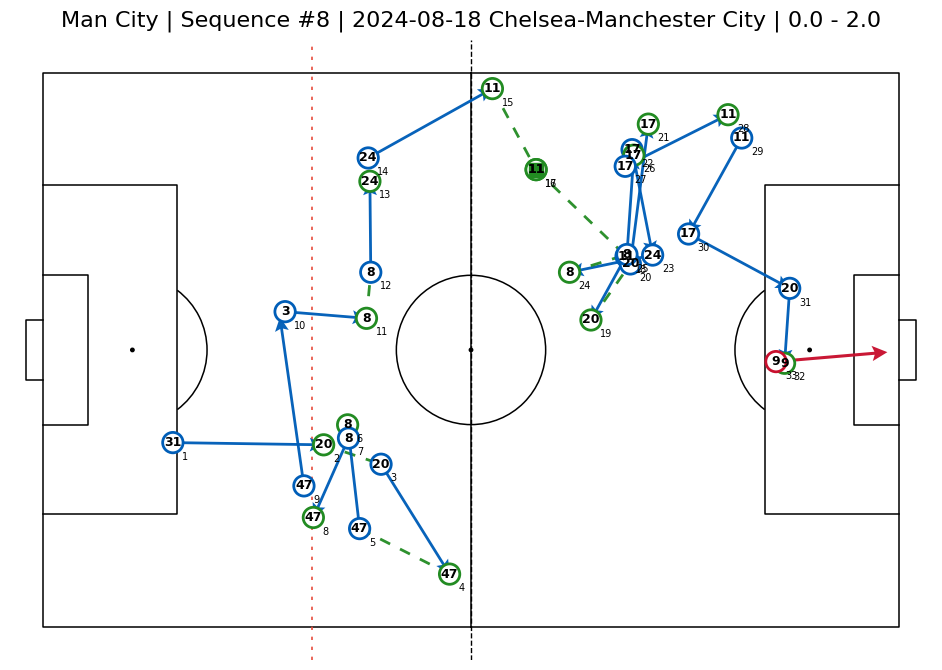

game_id team_name      player_name  jersey_number type_name  start_x  \
0  1821051.0  Man City   Bernardo Silva           20.0      pass   78.645   
1  1821051.0  Man City  Kevin De Bruyne           17.0   dribble   82.320   
2  1821051.0  Man City  Kevin De Bruyne           17.0      shot   81.690   

   start_y   end_x   end_y    sequence_id  period_id  pass_number  \
0   49.980   82.32  35.836  1821051-167-9        2.0            1   
1   35.836   81.69  34.204  1821051-167-9        2.0            1   
2   34.204  105.00  28.424  1821051-167-9        2.0            1   

   is_synthetic_carry  timestamp_min  
0               False          33.38  
1                True          33.40  
2               False          33.42

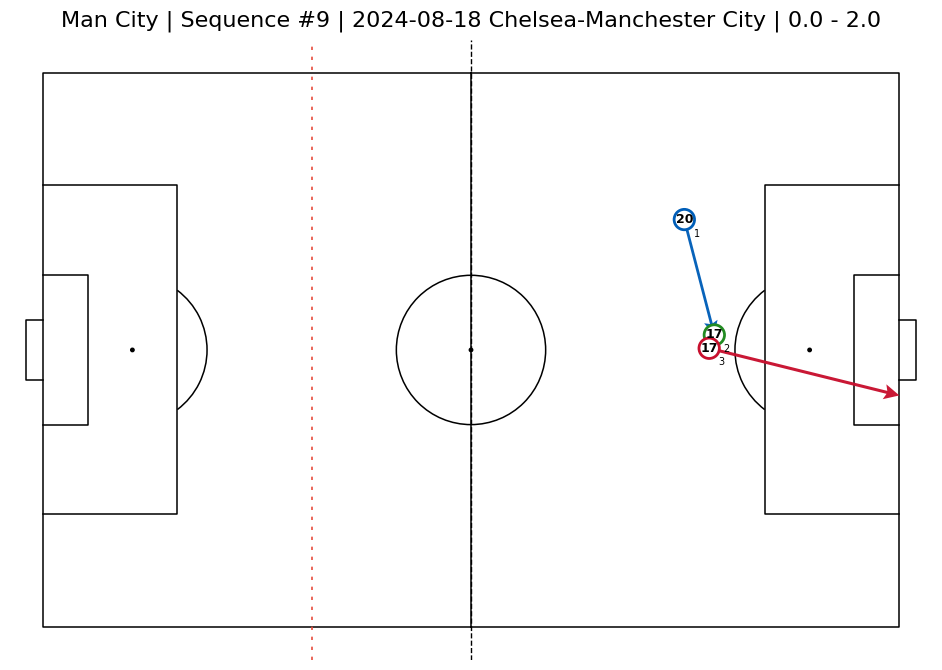

game_id team_name      player_name  jersey_number type_name  start_x  \
0  1821065.0  Man City          Savinho           26.0      pass   85.575   
1  1821065.0  Man City  Kevin De Bruyne           17.0   dribble   82.110   
2  1821065.0  Man City  Kevin De Bruyne           17.0   dribble   78.120   
3  1821065.0  Man City  Kevin De Bruyne           17.0      shot   81.690   

   start_y   end_x   end_y    sequence_id  period_id  pass_number  \
0   35.020   82.11  34.884  1821065-167-1        1.0            1   
1   34.884   78.12  36.244  1821065-167-1        1.0            1   
2   36.244   81.69  36.040  1821065-167-1        1.0            1   
3   36.040  105.00  35.632  1821065-167-1        1.0            1   

   is_synthetic_carry  timestamp_min  
0               False          13.60  
1               False          13.61  
2               False          13.62  
3               False          13.63

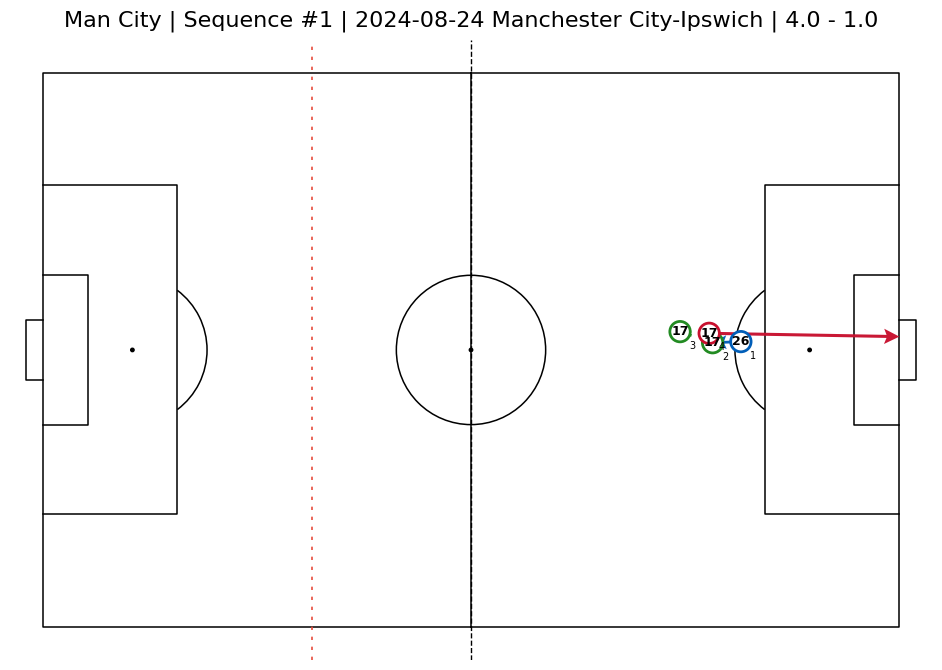

In [5]:
# # PLOT BUILDUP SEQUENCES
target_sequence_ids = shot_ending_sequences[
        (shot_ending_sequences['team_name']=='Man City')
]['sequence_id'].unique()
#["1821056-183-12", "1821056-183-13", "1821380-183-4", "1821426-183-6"]
plot_sequences_by_id(
    shot_ending_sequences,
    target_sequence_ids,
    show_table=True, 
    max_sequences=10
)

# Sequence Metrics

In [ ]:
pl_openplay_sequences = detect_open_play_sequences(
    pl_actions_data,
    apply_qc=True,
    qc_steps=("gap_flag", "interpolate"),
    dx_gap_thresh=20.0,
    dy_gap_thresh=13.0,
    interpolate_min_gap=1.0,
    interpolate_operate_on="clean",
)
from soccerchain_wrap.metrics.sequence_summary import summarize_open_play_sequences, PitchDims

seq_df = summarize_open_play_sequences(pl_openplay_sequences, cross_requires_pass=False)

In [5]:
import pandas as pd
from soccerchain_wrap.metrics.sequence_summary import summarize_open_play_sequences, PitchDims


# seq_df = summarize_open_play_sequences(
#     pl_openplay_sequences,
#     dims=PitchDims(),          # or PitchDims(length=100, width=64) if your pitch is different
#     long_ball_min_len=30.0     # tweak if your definition differs (e.g., 25.0)
# )

seq_df = summarize_open_play_sequences(pl_openplay_sequences, cross_requires_pass=False)

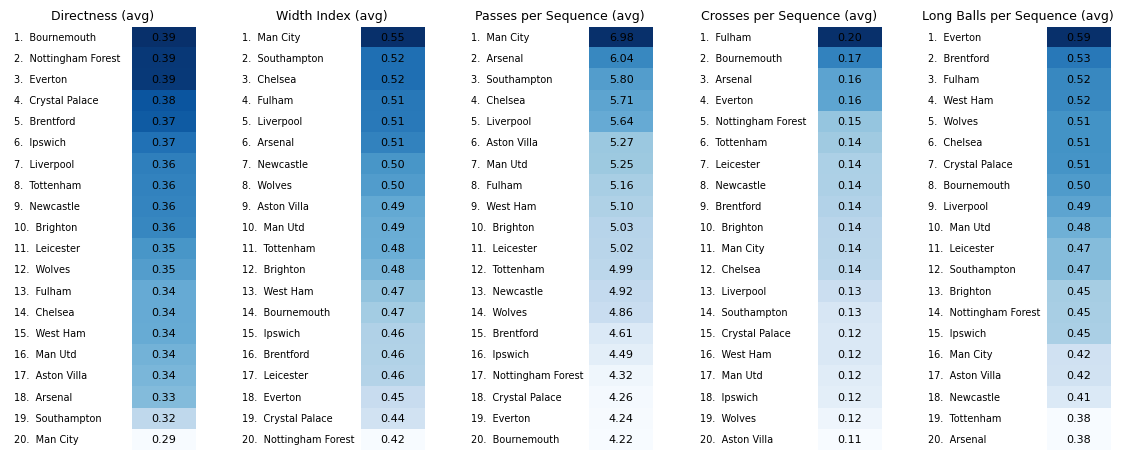

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def make_team_table(seq_df, team_col="team_name", min_sequences=1):
    if team_col not in seq_df.columns or seq_df[team_col].isna().all():
        team_col = "team_id"

    team = (
        seq_df.groupby(team_col, dropna=False)
              .agg(
                  sequences=("sequence_id", "nunique"),
                  directness=("directness", "mean"),
                  width_index=("width_index", "mean"),
                  passes_per_sequence=("n_passes", "mean"),
                  crosses_per_sequence=("n_crosses", "mean"),
                  long_balls_per_sequence=("n_long_balls", "mean"),
              )
              .reset_index()
              .rename(columns={team_col: "team"})
    )
    team = team.loc[team["sequences"] >= min_sequences].copy()

    for m in ["directness","width_index","passes_per_sequence",
              "crosses_per_sequence","long_balls_per_sequence"]:
        team[m + "_rank"] = team[m].rank(ascending=False, method="min").astype(int)
    return team


def plot_columns_ranked_by_metric(
    team_tbl: pd.DataFrame,
    metrics = (
        ("directness", "Directness (avg)", "{:.2f}"),
        ("width_index", "Width Index (avg)", "{:.2f}"),
        ("passes_per_sequence", "Passes per Sequence (avg)", "{:.2f}"),
        ("crosses_per_sequence", "Crosses per Sequence (avg)", "{:.2f}"),
        ("long_balls_per_sequence", "Long Balls per Sequence (avg)", "{:.2f}"),
    ),
    cmap="Blues",
    cell_h=0.24,         # smaller row height
    col_w=2.4,           # width per metric column
    pad_w=0.55,          # spacing between columns
    base_label_area=1.0, # minimum left space before heat
    title_size=9, label_size=8, value_size=8,
    max_team_chars=None  # e.g. 20 to truncate names; None = no truncation
):
    nteams = len(team_tbl)
    ncols  = len(metrics)

    # estimate longest "rank. team" string to auto-size left margin
    label_samples = []
    for col, _, _ in metrics:
        s = team_tbl.sort_values(col, ascending=False)
        label_samples += [f"{r}.  {t}" for r, t in zip(s[col + "_rank"], s["team"].astype(str))]
    max_chars = max(len(x) for x in label_samples) if label_samples else 12
    # heuristic: characters → axis units; add a small cushion
    label_area = base_label_area + 0.055 * max_chars

    # optional truncation to keep things tidy
    if max_team_chars:
        team_tbl = team_tbl.copy()
        team_tbl["team"] = team_tbl["team"].astype(str).apply(
            lambda t: t if len(t) <= max_team_chars else t[:max_team_chars-1] + "…"
        )

    fig_h = cell_h * nteams + 1.1
    fig_w = ncols * col_w + (ncols - 1) * pad_w
    fig, axes = plt.subplots(
        nrows=1, ncols=ncols, figsize=(fig_w, fig_h),
        gridspec_kw=dict(wspace=pad_w/col_w)
    )
    if ncols == 1:
        axes = [axes]
    fig.patch.set_facecolor("white")

    for ax, (col, title, fmt) in zip(axes, metrics):
        s = team_tbl.sort_values(col, ascending=False, kind="stable").reset_index(drop=True)
        vals  = s[col].to_numpy()
        ranks = s[col + "_rank"].to_numpy()
        teams = s["team"].astype(str).tolist()

        # draw heat strip
        mat = vals.reshape(-1, 1)
        im = ax.imshow(mat, aspect="auto", cmap=cmap,
                       vmin=np.nanmin(vals), vmax=np.nanmax(vals))

        # widen axis to the left for the labels
        ax.set_xlim(-label_area, 0.5)
        ax.set_ylim(nteams - 0.5, -0.5)
        ax.set_xticks([]); ax.set_yticks([])

        # left labels (rank. team), placed safely away from the heat
        xlab = -label_area + 0.06
        for i, (r, t) in enumerate(zip(ranks, teams)):
            ax.text(xlab, i, f"{r}.  {t}", ha="left", va="center",
                    fontsize=label_size)  # <-- no bold

        # numeric value inside the cell (no bold)
        for i, v in enumerate(vals):
            ax.text(0, i, fmt.format(v), ha="center", va="center",
                    fontsize=value_size)

        # slimmer, non-bold title
        ax.set_title(title, fontsize=title_size, pad=5)  # <-- no fontweight

        # clean frame
        for sp in ax.spines.values():
            sp.set_visible(False)

    plt.tight_layout()
    plt.show()

# seq_df = <your DataFrame>
team_tbl = make_team_table(seq_df, min_sequences=10)
plot_columns_ranked_by_metric(
    team_tbl,
    cell_h=0.22,          # even smaller rows if needed
    base_label_area=1.2,  # bump if names still touch the heat
    label_size=7,         # ↓ smaller team-name font
    value_size=8,
    title_size=9,
    max_team_chars=22     # optional
)


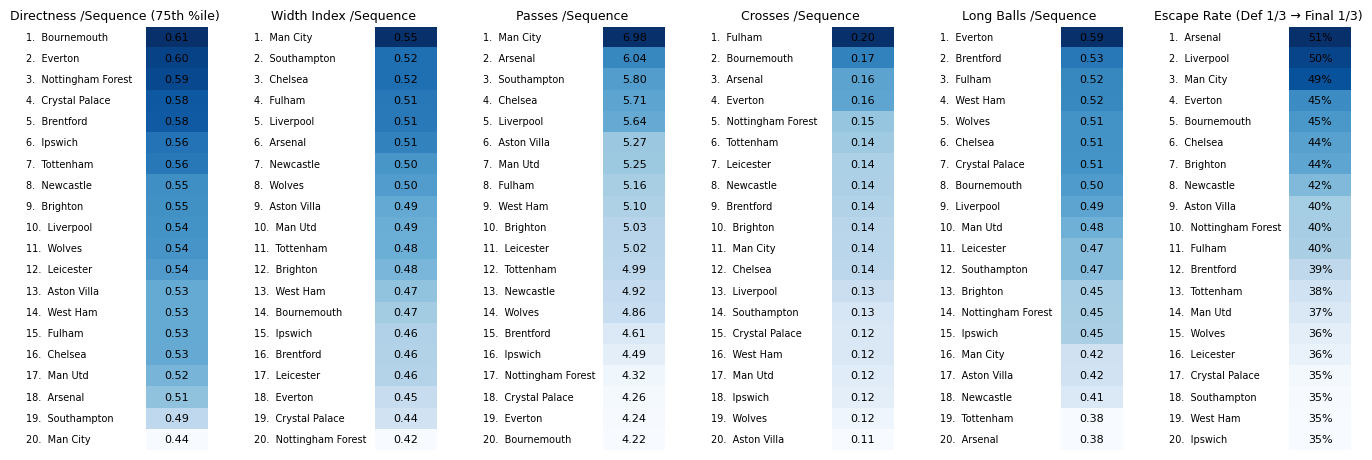

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def make_team_table(
    seq_df,
    team_col="team_name",
    min_sequences=1,
    *,
    pitch_length=105.0,
    escape_target="final_third",  # "final_third" (default) or "halfway"
):
    """
    Aggregates sequence-level table to team level and adds Escape Rate:
      - start in defensive third (start_x < L/3)
      - finish in target zone:
          * final_third: end_x >= 2L/3
          * halfway:     end_x >= L/2
    """
    if team_col not in seq_df.columns or seq_df[team_col].isna().all():
        team_col = "team_id"

    L = float(pitch_length)
    start_def3rd = pd.to_numeric(seq_df["start_x"], errors="coerce") < (L / 3.0)

    if escape_target == "final_third":
        dest_flag = pd.to_numeric(seq_df["end_x"], errors="coerce") >= (2.0 * L / 3.0)
        # use precomputed column if you already have it; otherwise derive
        escaped = seq_df.get("def3rd_to_final_third", start_def3rd & dest_flag)
    else:  # fallback/back-compat
        dest_flag = pd.to_numeric(seq_df["end_x"], errors="coerce") >= (L / 2.0)
        escaped = seq_df.get("def3rd_to_beyond_half", start_def3rd & dest_flag)

    df = seq_df.copy()
    df["start_def3rd"] = start_def3rd
    df["escaped"] = escaped

    team = (
        df.groupby(team_col, dropna=False)
          .agg(
              sequences=("sequence_id", "nunique"),
              directness=("directness", "mean"),
              directness_p75=("directness", lambda s: s.quantile(0.75)),
              width_index=("width_index", "mean"),
              passes_per_sequence=("n_passes", "mean"),
              crosses_per_sequence=("n_crosses", "mean"),
              long_balls_per_sequence=("n_long_balls", "mean"),
              def3rd_sequences=("start_def3rd", "sum"),
              escape_count=("escaped", "sum"),
          )
          .reset_index()
          .rename(columns={team_col: "team"})
    )

    team["escape_rate"] = np.where(
        team["def3rd_sequences"] > 0,
        team["escape_count"] / team["def3rd_sequences"],
        np.nan,
    )

    # ranks (higher better)
    for m in ["directness_p75","width_index","passes_per_sequence",
              "crosses_per_sequence","long_balls_per_sequence","escape_rate"]:
        valid = team[m].notna()
        rk = pd.Series(np.nan, index=team.index, dtype="float64")
        rk.loc[valid] = team.loc[valid, m].rank(ascending=False, method="min")
        team[m + "_rank"] = rk.astype("Int64")

    team = team.loc[team["sequences"] >= min_sequences].reset_index(drop=True)
    return team




def plot_columns_ranked_by_metric(
    team_tbl: pd.DataFrame,
    metrics = (
        ("directness", "Directness per Sequence", "{:.2f}"),
        ("width_index", "Width Index per Sequence", "{:.2f}"),
        ("passes_per_sequence", "Passes per Sequence", "{:.2f}"),
        ("crosses_per_sequence", "Crosses per Sequence", "{:.2f}"),
        ("long_balls_per_sequence", "Long Balls per Sequence", "{:.2f}"),
        # NEW COLUMN
        ("escape_rate", "Escape Rate (Def 1/3 → >Half)", "{:.0%}"),
    ),
    cmap="Blues",
    cell_h=0.24,
    col_w=2.4,
    pad_w=0.55,
    base_label_area=1.2,
    title_size=9, label_size=7, value_size=8,
    max_team_chars=None
):
    nteams = len(team_tbl)
    ncols  = len(metrics)

    # estimate longest "rank. team" string to size left margin
    label_samples = []
    for col, _, _ in metrics:
        s = team_tbl.sort_values(col, ascending=False)
        label_samples += [f"{r if pd.notna(r) else '-'}.  {t}"
                          for r, t in zip(s[col + "_rank"], s["team"].astype(str))]
    max_chars = max(len(x) for x in label_samples) if label_samples else 12
    label_area = base_label_area + 0.055 * max_chars

    if max_team_chars:
        team_tbl = team_tbl.copy()
        team_tbl["team"] = team_tbl["team"].astype(str).apply(
            lambda t: t if len(t) <= max_team_chars else t[:max_team_chars-1] + "…"
        )

    fig_h = cell_h * nteams + 1.1
    fig_w = ncols * col_w + (ncols - 1) * pad_w
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(fig_w, fig_h),
                             gridspec_kw=dict(wspace=pad_w/col_w))
    if ncols == 1:
        axes = [axes]
    fig.patch.set_facecolor("white")

    for ax, (col, title, fmt) in zip(axes, metrics):
        s = team_tbl.sort_values(col, ascending=False, kind="stable").reset_index(drop=True)
        vals  = s[col].to_numpy()
        ranks = s[col + "_rank"].to_numpy()
        teams = s["team"].astype(str).tolist()

        mat = vals.reshape(-1, 1)
        # guard against all-NaN column
        vmin = np.nanmin(vals) if np.isfinite(np.nanmin(vals)) else 0.0
        vmax = np.nanmax(vals) if np.isfinite(np.nanmax(vals)) else 1.0
        im = ax.imshow(mat, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)

        ax.set_xlim(-label_area, 0.5)
        ax.set_ylim(nteams - 0.5, -0.5)
        ax.set_xticks([]); ax.set_yticks([])

        xlab = -label_area + 0.06
        for i, (r, t) in enumerate(zip(ranks, teams)):
            rtxt = "-" if pd.isna(r) else f"{int(r)}"
            ax.text(xlab, i, f"{rtxt}.  {t}", ha="left", va="center",
                    fontsize=label_size)

        for i, v in enumerate(vals):
            txt = "–" if pd.isna(v) else fmt.format(v)
            ax.text(0, i, txt, ha="center", va="center", fontsize=value_size)

        ax.set_title(title, fontsize=title_size, pad=5)
        for sp in ax.spines.values():
            sp.set_visible(False)

    plt.tight_layout()
    plt.show()


team_tbl = make_team_table(seq_df, min_sequences=10, pitch_length=105.0,
                           escape_target="final_third")

plot_columns_ranked_by_metric(
    team_tbl,
    metrics=(
        ("directness_p75", "Directness /Sequence (75th %ile)", "{:.2f}"),
        ("width_index", "Width Index /Sequence", "{:.2f}"),
        ("passes_per_sequence", "Passes /Sequence", "{:.2f}"),
        ("crosses_per_sequence", "Crosses /Sequence", "{:.2f}"),
        ("long_balls_per_sequence", "Long Balls /Sequence", "{:.2f}"),
        ("escape_rate", "Escape Rate (Def 1/3 → Final 1/3)", "{:.0%}"),
    ),
    base_label_area=1.3, cell_h=0.22, label_size=7, value_size=8, title_size=9, max_team_chars=22
)


# Shot Ending Sequences

In [ ]:
# DETECT BUILDUP SEQUENCES
shot_ending_sequences = detect_shot_ending_sequences(
    pl_actions_data,
    apply_qc=True,
    qc_steps=("gap_flag", "interpolate"),
    dx_gap_thresh=20.0,
    dy_gap_thresh=13.0,
    interpolate_min_gap=1.0,
    interpolate_operate_on="clean",
)
shot_ending_sequences


tbl, fig = shot_seq_donut_mpl(shot_ending_sequences, team="Arsenal",
                              label_pos=0.4, label_size=10)

tbl, fig = plot_top_support_players(shot_ending_sequences, team="Arsenal",
                                    top_n=5, fig_width=8.0, inside_label_size=8, player_fontsize=8)

plt.show()

game_id original_event_id  period_id  time_seconds  team_id  \
0      1821049.0        2709318109        1.0         410.0    170.0   
1      1821049.0               NaN        1.0         413.5    170.0   
2      1821049.0        2709318147        1.0         417.0    170.0   
3      1821049.0               NaN        1.0         418.0    170.0   
4      1821049.0        2709318191        1.0         419.0    170.0   
...          ...               ...        ...           ...      ...   
56607  1821428.0        2779643883        2.0        3245.0     24.0   
56608  1821428.0               NaN        2.0        3248.5     24.0   
56609  1821428.0        2779643913        2.0        3252.0     24.0   
56610  1821428.0               NaN        2.0        3253.0     24.0   
56611  1821428.0        2779643925        2.0        3254.0     24.0   

       player_id  start_x   end_x  start_y   end_y  ...    sequence_id  \
0       297395.0   67.305  66.150   19.924  31.892  ...  1821049-170-1   
1       136824.0   66.150  63.105   31.892  50.116  ...  1821049-170-1   
2       136824.0   63.105  54.600   50.116  40.528  ...  1821049-170-1   
3       396976.0   54.600  54.600   40.528  39.304  ...  1821049-170-1   
4       396976.0   54.600  58.065   39.304  28.288  ...  1821049-170-1   
...          ...      ...     ...      ...     ...  ...            ...   
56607   137467.0   55.860  87.465   49.028  61.744  ...   1821428-24-9   
56608   300299.0   87.465  94.080   61.744  54.536  ...   1821428-24-9   
56609   300299.0   94.080  94.080   54.536  54.536  ...   1821428-24-9   
56610   300299.0   94.080  90.405   54.536  45.356  ...   1821428-24-9   
56611   300299.0   90.405  92.610   45.356  43.928  ...   1821428-24-9   

       in_sequence  sequence_valid  seq_num_passes seq_max_dx_gap  \
0             True            True            15.0          6.510   
1             True            True            15.0          6.510   
2             True            True            15.0          6.510   
3             True            True             NaN            NaN   
4             True            True            15.0          6.510   
...            ...             ...             ...            ...   
56607         True            True             1.0          3.675   
56608         True            True             1.0          3.675   
56609         True            True             1.0          3.675   
56610         True            True             NaN            NaN   
56611         True            True             1.0          3.675   

      seq_max_dy_gap seq_gap_dx_thresh seq_gap_dy_thresh sequence_gap  \
0              3.944              20.0              13.0          0.0   
1              3.944              20.0              13.0          0.0   
2              3.944              20.0              13.0          0.0   
3                NaN               NaN               NaN          NaN   
4              3.944              20.0              13.0          0.0   
...              ...               ...               ...          ...   
56607          9.180              20.0              13.0          0.0   
56608          9.180              20.0              13.0          0.0   
56609          9.180              20.0              13.0          0.0   
56610            NaN               NaN               NaN          NaN   
56611          9.180              20.0              13.0          0.0   

      is_synthetic_carry  
0                  False  
1                  False  
2                  False  
3                   True  
4                  False  
...                  ...  
56607              False  
56608              False  
56609              False  
56610               True  
56611              False  

[52485 rows x 37 columns]

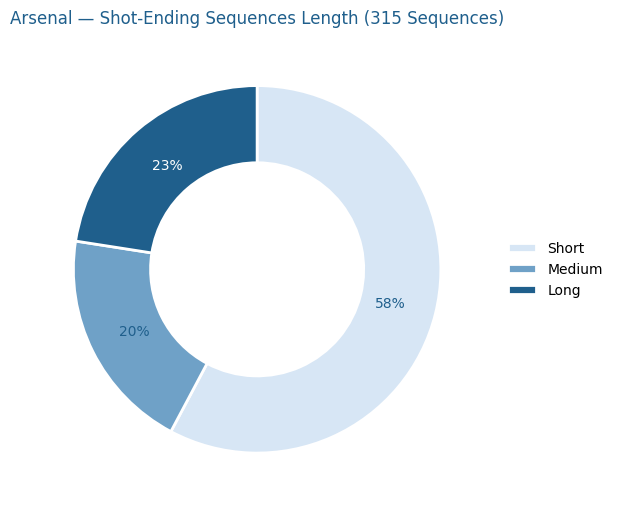

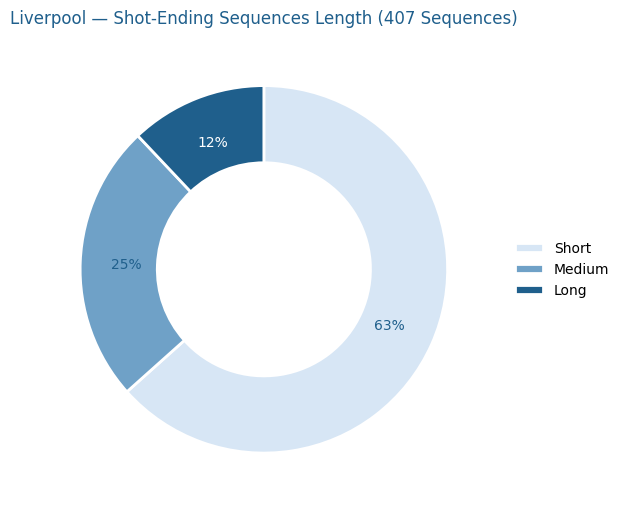

In [ ]:
from typing import Optional
import pandas as pd, numpy as np, matplotlib.pyplot as plt

def shot_seq_donut_mpl(df: pd.DataFrame,
                       team: str,
                       short_max: int = 4,
                       long_min: int = 10,
                       title: Optional[str] = None,
                       annot_min: float = 2.0,
                       label_size: int = 12,
                       label_pos: float = 0.5):  # 0..1 across the ring; 0.5 = centered
    """Donut of shot-ending sequences by length (Short/Medium/Long) for one team."""
    d = df[(df["team_name"] == team) & df["sequence_valid"]].copy()
    if d.empty:
        return pd.DataFrame(columns=["bucket","count","percent"]), None

    # passes per sequence (prefer precomputed)
    if "seq_num_passes" in d and d["seq_num_passes"].notna().any():
        seq_len = (d.dropna(subset=["sequence_id"])
                    .groupby("sequence_id")["seq_num_passes"].max().astype(int))
    else:
        seq_len = (d.assign(is_pass=d["type_name"].astype(str).str.lower().eq("pass"))
                    .groupby("sequence_id")["is_pass"].sum().astype(int))

    # buckets
    def bucket(n): return "Short" if n <= short_max else ("Long" if n >= long_min else "Medium")
    dist = seq_len.map(bucket).value_counts().reindex(["Short","Medium","Long"], fill_value=0)
    out = dist.rename_axis("bucket").reset_index(name="count")
    out["percent"] = out["count"] / out["count"].sum() * 100

    # donut
    colors = ["#D7E6F5", "#6FA1C7", "#1F5F8C"]  # light -> dark brand blues
    vals, labels = out["count"].to_numpy(), out["bucket"].tolist()
    total = int(vals.sum())

    fig, ax = plt.subplots(figsize=(7.6, 5.2))
    ring_width = 0.42
    wedges, _ = ax.pie(
        vals, startangle=90, counterclock=False, colors=colors,
        wedgeprops=dict(width=ring_width, edgecolor="white", linewidth=2)
    )

    # place % at the geometric center of each slice (radius midway across the ring)
    r_in = 1.0 - ring_width
    r_lab = r_in + ring_width * np.clip(label_pos, 0.0, 1.0)

    for w, pct in zip(wedges, out["percent"].to_numpy()):
        if pct < annot_min:
            continue
        ang = np.deg2rad((w.theta2 + w.theta1) / 2.0)
        x, y = r_lab * np.cos(ang), r_lab * np.sin(ang)
        r, g, b, _ = w.get_facecolor()
        luminance = 0.2126*r + 0.7152*g + 0.0722*b
        txt_color = "white" if luminance < 0.55 else "#1F5F8C"
        ax.text(x, y, f"{pct:.0f}%", ha="center", va="center",
                fontsize=label_size, color=txt_color, clip_on=False)

    # legend (labels only)
    ax.legend(wedges, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    ax.set(aspect="equal")
    for s in ax.spines.values(): s.set_visible(False)
    ax.set_title((title or f"{team} — Shot-Ending Sequences Length") + f" ({total} Sequences)",
                 color="#1F5F8C", pad=12, fontsize=12)
    fig.tight_layout()
    return out, fig


# default (labels centered in the ring)
tbl, fig = shot_seq_donut_mpl(shot_ending_sequences, team="Arsenal",
                              label_pos=0.4, label_size=10)
plt.show()

# labels a touch closer to the inner hole, smaller font
tbl, fig = shot_seq_donut_mpl(shot_ending_sequences, team="Liverpool",
                               label_pos=0.4, label_size=10)
plt.show()


player_name former_position  sequences  pct_of_sequences
0        Mohamed Salah             AMR        134              32.9
1  Alexis Mac Allister             DMC        104              25.6
2     Ryan Gravenberch             DMC        103              25.3
3            Luis Díaz              FW        100              24.6
4   Dominik Szoboszlai             AMC         99              24.3

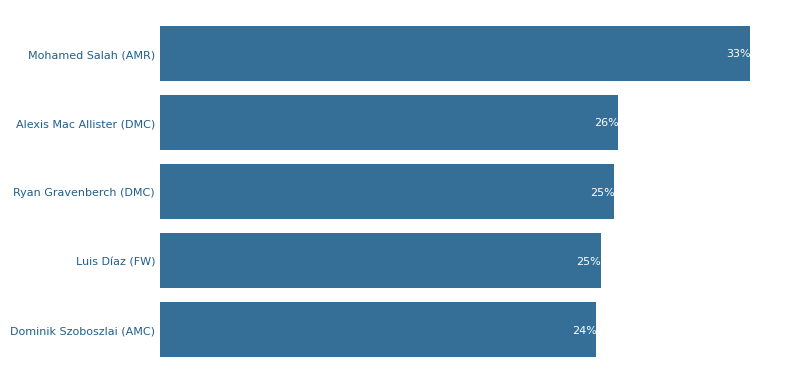

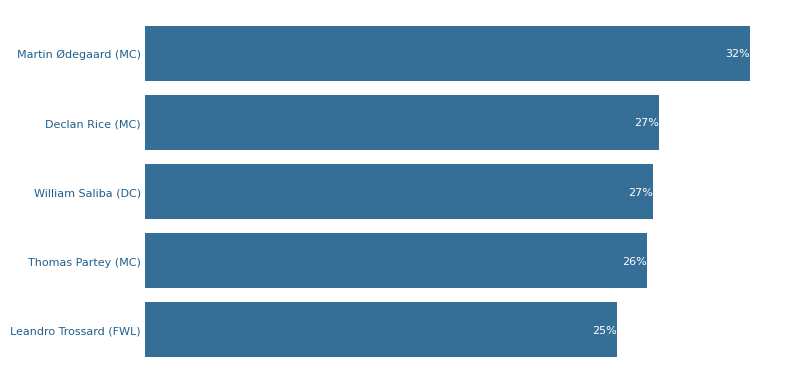

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple

def plot_top_support_players(
    shot_end_df: pd.DataFrame,
    team: str,
    top_n: int = 5,
    color: str = "#1F5F8C",
    fig_width: float = 8.0,            # constant width across teams
    bar_height: float = 0.55,          # bar thickness / vertical spacing
    player_fontsize: int = 9,
    inside_label_size: int = 12,
) -> Tuple[pd.DataFrame, plt.Figure]:
    """
    Rank players by involvement in shot-ending sequences, excluding the SHOT
    and the final pre-shot action. Counts are unique per sequence.

    Returns (summary_df, fig) with columns:
      player_name, former_position, sequences, pct_of_sequences
    """
    d = shot_end_df[
        (shot_end_df["team_name"] == team) & shot_end_df["sequence_valid"].astype(bool)
    ].copy()
    if d.empty:
        return pd.DataFrame(columns=["player_name","former_position","sequences","pct_of_sequences"]), plt.figure()

    # order events within each sequence
    d["time_seconds"] = pd.to_numeric(d["time_seconds"], errors="coerce")
    sort_cols = ["sequence_id", "time_seconds"]
    if "original_event_id" in d.columns:
        sort_cols.append("original_event_id")
    d = d.sort_values(sort_cols)

    # index within sequence and remove last two events (pre-shot + shot)
    d["ord_in_seq"] = d.groupby("sequence_id").cumcount()
    last_ord = d.groupby("sequence_id")["ord_in_seq"].transform("max")
    core = d.loc[d["ord_in_seq"] <= (last_ord - 2), ["sequence_id","player_name","former_position"]]
    core = core.dropna(subset=["player_name"])

    # unique player participation per sequence
    part = core.drop_duplicates(["sequence_id","player_name"])

    # totals
    n_seq = d["sequence_id"].nunique()
    counts = (part.groupby(["player_name","former_position"]).size()
              .sort_values(ascending=False).head(top_n)
              .rename("sequences").reset_index())
    counts["pct_of_sequences"] = (counts["sequences"] / max(n_seq, 1) * 100).round(1)

    # y labels: "Player (POS)"
    counts["label"] = counts.apply(
        lambda r: f"{r['player_name']} ({str(r['former_position'])})" if pd.notna(r["former_position"]) else r["player_name"],
        axis=1
    )

    # --- plotting (clean, Opta/Athletic-ish) ---
    n = len(counts)
    fig_height = max(3.2, bar_height * n + 1.2)  # width fixed, height adapts to #bars
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    y = counts["label"][::-1]
    v = counts["sequences"][::-1].to_numpy()
    pct = counts["pct_of_sequences"][::-1].to_numpy()

    ax.barh(y, v, color=color, alpha=0.9)

    # % labels inside bars (white text if bar is dark)
    vmax = v.max() if n else 1
    pad = max(0.02 * vmax, 0.5)  # distance from right edge
    for i, (c, p) in enumerate(zip(v, pct)):
        x = max(c - pad, c * 0.6)  # keep inside even for small bars
        txt_color = "white"  # dark blue bars → white pops best
        ax.text(x, i, f"{p:.0f}%", ha="center", va="center",
                fontsize=inside_label_size, color=txt_color)

    # style: no grids, no x axis labels/ticks, tidy spines
    ax.set_xlim(0, vmax * 1.05 if n else 1)
    ax.set_xlabel("")
    ax.set_xticks([]); ax.tick_params(axis="x", length=0)
    ax.set_ylabel("")
    ax.set_yticks(range(n)); ax.set_yticklabels(y, color=color, fontsize=player_fontsize)
    ax.tick_params(axis="y", length=0)

    for spine in ax.spines.values():
        spine.set_visible(False)

    #ax.set_title(f"{team} — Top {n} supporters in shot-ending sequences\n(excluding last two actions)",
    #            color=color, fontsize=12, pad=10)

    fig.tight_layout()
    return counts[["player_name","former_position","sequences","pct_of_sequences"]], fig

tbl, fig = plot_top_support_players(shot_ending_sequences, team="Liverpool",
                                    top_n=5, fig_width=8.0, inside_label_size=8, player_fontsize=8)
display(tbl); plt.show()

tbl, fig = plot_top_support_players(shot_ending_sequences, team="Arsenal",
                                    top_n=5, fig_width=8.0, inside_label_size=8, player_fontsize=8)
plt.show()


# Sequence Metrics